In [1]:
## ----- Imports -----
import sys
sys.path.append('.')
from mylib import *
from sklearn.model_selection import train_test_split, \
cross_val_score



# Utils

In [2]:


def show_stim(config, roi):
  config = config-1
  roi = roi-1
  plt.clf()
  plt.gcf().subplots(2,3,sharey=True)
  for session_id in range(3):
    plt.subplot(1, 3, session_id+1)
    plt.title(f'Session{session_id+1}')
    for i in range(8):
      a = times[0,session_id][i,config] - 0 - 1
      b = times[0,session_id][i,config] + 40 - 1
      plt.plot(dfof[0,session_id][a:b, roi], 'k')
    plt.ylabel('dfof')
    plt.xlabel('frames')
    
    
def leaveoneout_nps(model,X,y):
  loo = LeaveOneOut()
  predictions = []
  actuals = []
  coefs = []
  for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions.append(y_pred[0])
    actuals.append(y_test[0])
    coefs.append(model.coef_)
  return actuals, predictions, np.array(coefs).mean(0)


def get_best_model_nps(model_fun, config, roi, pp, ran=[None], plot=False, all_in=True, model_name=''):
  x, X, y = get_values(config, roi, pp)

  
  all_r2 = []
  all_p = []
  all_rois = []

  for p in ran:
    if p is None:
      model = model_fun()
    else:
      model = model_fun(p, max_iter=100000)
    if not all_in:
      X = x
    ac, pred, coef = leaveoneout_nps(model, X, y)
#     if plot:
#       label = f'Parameter : {p}'
#       plot_actuals_predictions(ac, pred, label)
    mse, r2 = get_mse_r2(ac, pred)
    all_r2.append(r2)
    all_p.append(p)
    all_rois.append(coef)
    
  best = np.argmax(all_r2)
  best_p = all_p[best]
  best_r2 = all_r2[best]
  best_roi = all_rois[best]
    
  if plot:
    plt.title(f'{model_name} [All - 1] [{config},{roi}] [{pp}]')
    plt.figure()
    plt.plot(np.log10(all_p),all_r2)
    plt.scatter([np.log10(best_p)],[best_r2],c='r')
    plt.xlabel('log-parameter')
    plt.ylabel('$R^2$')
    plt.title(f'{model_name} [All - 1] [{config},{roi}] [{pp}]')
    plt.show()
  return best_p, best_r2, best_roi


def compare_models(config, roi):
  _, r2_lin = get_best_model(LinearRegression, config, roi, 'pre-post', None, False, False)
  _, r2_ridge = get_best_model(Ridge, config, roi, 'pre-post', [0.1,2,0.1], False)
  _, r2_lasso = get_best_model(Lasso, config, roi, 'pre-post', [0.001,0.01,0.001], False)
  _, r2_pls = get_best_model(PLSRegression, config, roi, 'pre-post', [1,10], False)

  _, r2_ridge1 = get_best_model(Ridge, config, roi, 'post-post', [0.1,2,0.1], False)
  _, r2_lasso1 = get_best_model(Lasso, config, roi, 'post-post', [0.001,0.01,0.001], False)
  _, r2_pls1 = get_best_model(PLSRegression, config, roi, 'post-post', [1,10], False)
  print(f'Model       Pre-Post \t Post-Post')
  print('R2 Lin11 : ', r2_lin, '\t', 'NA')
  print('R2 Ridge : ', r2_ridge, '\t', r2_ridge1)
  print('R2 Lasso : ', r2_lasso, '\t', r2_lasso1)
  print('R2 PLS   : ', r2_pls, '\t', r2_pls1)
    
    



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
!pip install scikit-image
from skimage.measure import regionprops, label
from matplotlib import cm
from matplotlib.colors import Normalize

def plot_roi_ellipses(roi_mask, ax=None, edgecolor='r', linewidth=2):
    """
    Plot best-fitting ellipses for each labeled ROI in a 2D mask.

    Parameters:
    - roi_mask (np.ndarray): 2D array where 0 = background, i = ROI for neuron i.
    - ax (matplotlib.axes.Axes): Optional. If provided, draws on this axis.
    - edgecolor (str): Edge color for ellipses.
    - linewidth (float): Width of the ellipse edges.

    Returns:
    - ax (matplotlib.axes.Axes): The axis with the drawn ellipses.
    """
    if ax is None:
        fig, ax = plt.subplots()
        ax.imshow(roi_mask, cmap='gray')

    labeled_mask = label(roi_mask > 0)  # Re-label in case labels are not consecutive
    props = regionprops(labeled_mask, intensity_image=roi_mask)

    for prop in props:
        y0, x0 = prop.centroid
        orientation = -np.rad2deg(prop.orientation)
        major_axis = prop.major_axis_length
        minor_axis = prop.minor_axis_length

        ellipse = Ellipse(
            (x0, y0),
            width=minor_axis,
            height=major_axis,
            angle=orientation,
            edgecolor=edgecolor,
            facecolor='none',
            linewidth=linewidth
        )
        ax.add_patch(ellipse)
#         ax.text(x0, y0, str(int(np.median(prop.intensity_image[prop.image]))), 
#                 color=edgecolor, fontsize=8, ha='center', va='center')

    ax.set_aspect('equal')
    ax.axis('off')
    return ax



def plot_roi_ellipses_colored(
    roi_mask,
    roi_intensities,
    cmap='viridis',
    clim=None,
    ax=None,
    edgecolor='k',
    linewidth=1
):
    """
    Plot ellipses fitted to each ROI, shaded by a scalar value (e.g., activity).

    Parameters:
    - roi_mask (np.ndarray): 2D array where 0 = background, i = ROI for neuron i.
    - roi_intensities (np.ndarray or list): 1D array, intensity per ROI (index = ROI label).
    - cmap (str or Colormap): Colormap used for shading.
    - clim (tuple or None): (vmin, vmax) for intensity normalization. If None, auto-scaled.
    - ax (matplotlib.axes.Axes): Optional. If provided, draws on this axis.
    - edgecolor (str): Edge color for the ellipses.
    - linewidth (float): Width of ellipse border.

    Returns:
    - ax (matplotlib.axes.Axes): The axis with the drawn ellipses.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.imshow(roi_mask * 0 + 1, cmap='gray', clim=[0, 1])

    labeled_mask = label(roi_mask > 0)
    props = regionprops(labeled_mask)

    # Auto-set clim if not provided
    if clim is None:
        valid_vals = roi_intensities[roi_intensities > 0]  # exclude background
        vmin = np.min(valid_vals)
        vmax = np.max(valid_vals)
    else:
        vmin, vmax = clim

    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap_func = cm.get_cmap(cmap)

    for prop in props:
        label_val = int(np.median(roi_mask[prop.coords[:, 0], prop.coords[:, 1]]))
        intensity = roi_intensities[label_val-1]
        fill_color = cmap_func(norm(intensity))

        y0, x0 = prop.centroid
        orientation = -np.rad2deg(prop.orientation)
        major_axis = prop.major_axis_length
        minor_axis = prop.minor_axis_length

        ellipse = Ellipse(
            (x0, y0),
            width=minor_axis,
            height=major_axis,
            angle=orientation,
            edgecolor=edgecolor,
            facecolor=fill_color,
            linewidth=linewidth
        )
        ax.add_patch(ellipse)
#         ax.text(x0, y0, str(label_val), color='w', fontsize=7, ha='center', va='center')

    ax.set_aspect('equal')
    ax.axis('off')
    return ax



In [4]:
from skimage.measure import regionprops, label
import matplotlib.lines as mlines

def plot_summary_figure(config, roi, roi_mask):
    fig, axs = plt.subplots(4, 3, figsize=(12, 10))
    fig.suptitle(f'Config {config}, ROI {roi}', fontsize=14)

    # -------- Row 1: Traces (Sessions 1-3) --------
    for session_id in range(3):
        ax = axs[0, session_id]
        ax.set_title(f'Session {session_id+1}')
        for i in range(8):
            a = times[0, session_id][i, config - 1] - 1
            b = times[0, session_id][i, config - 1] + 40 - 1
            ax.plot(dfof[0, session_id][a:b, roi - 1], 'k', alpha=0.6)
        ax.set_ylabel('dF/F')
        ax.set_xlabel('Frames')

    # -------- Get data and linear 1-1 baseline --------
    x, X, y = get_values(config, roi, 'pre-post')
    _, r2_lin, _ = get_best_model_nps(LinearRegression, config, roi, 'pre-post',
                                      [None], plot=False, all_in=False)

    # -------- Row 2: R² vs alpha (Ridge & Lasso) --------
    alphas = np.power(10, np.arange(-6, 4, 0.1))

    # Ridge
    ridge_r2s = []
    ridge_weights = []
    for alpha in alphas:
        model = Ridge(alpha=alpha, max_iter=100000)
        ac, pred, coef = leaveoneout_nps(model, X, y)
        mse, r2 = get_mse_r2(ac, pred)
        ridge_r2s.append(r2)
        ridge_weights.append(coef)
    best_ridge_idx = np.argmax(ridge_r2s)
    best_ridge_alpha = alphas[best_ridge_idx]
    best_ridge_r2 = ridge_r2s[best_ridge_idx]
    best_ridge_coef = ridge_weights[best_ridge_idx]

    axs[1, 0].plot(np.log10(alphas), ridge_r2s, label='Ridge')
    axs[1, 0].axhline(r2_lin, color='k', linestyle='--', label='Lin 1-1')
    axs[1, 0].scatter(np.log10(best_ridge_alpha), best_ridge_r2, color='r')
    axs[1, 0].set_ylabel('$R^2$')
    axs[1, 0].set_title('Ridge $R^2$')

    # Lasso
    lasso_r2s = []
    lasso_weights = []
    for alpha in alphas:
        model = Lasso(alpha=alpha, max_iter=100000)
        ac, pred, coef = leaveoneout_nps(model, X, y)
        mse, r2 = get_mse_r2(ac, pred)
        lasso_r2s.append(r2)
        lasso_weights.append(coef)
    best_lasso_idx = np.argmax(lasso_r2s)
    best_lasso_alpha = alphas[best_lasso_idx]
    best_lasso_r2 = lasso_r2s[best_lasso_idx]
    best_lasso_coef = lasso_weights[best_lasso_idx]

    axs[1, 1].plot(np.log10(alphas), lasso_r2s, label='Lasso')
    axs[1, 1].axhline(r2_lin, color='k', linestyle='--', label='Lin 1-1')
    axs[1, 1].scatter(np.log10(best_lasso_alpha), best_lasso_r2, color='r')
    axs[1, 1].set_title('Lasso $R^2$')

    # R² Legend (Row 2, Col 3)
    axs[1, 2].axis('off')
    r2_texts = [
        f'Lin 1-1  $R^2$ = {r2_lin:.2f}',
        f'Ridge    $R^2$ = {best_ridge_r2:.2f}',
        f'Lasso    $R^2$ = {best_lasso_r2:.2f}'
    ]
    dummy_handles = [mlines.Line2D([], [], color='none') for _ in r2_texts]
    axs[1, 2].legend(
        dummy_handles, r2_texts,
        loc='center', fontsize=10,
        frameon=False, handlelength=0, handletextpad=0
    )

    # -------- Row 3: Actual vs Predicted --------
    ac, pred = leaveoneout(LinearRegression(), x, y)
    axs[2, 0].plot(ac, pred, 'o')
    axs[2, 0].plot([min(ac), max(ac)], [min(ac), max(ac)], 'k--')
    axs[2, 0].set_title('Lin 1-1')
    axs[2, 0].set_xlabel('Acutal')
    axs[2, 0].set_ylabel('Predicted')
    

    best_ridge_model = Ridge(alpha=best_ridge_alpha)
    ac, pred, _ = leaveoneout_nps(best_ridge_model, X, y)
    axs[2, 1].plot(ac, pred, 'o')
    axs[2, 1].plot([min(ac), max(ac)], [min(ac), max(ac)], 'k--')
    axs[2, 1].set_title(f'Ridge α={best_ridge_alpha:.1e}')
    axs[2, 1].set_xlabel('Acutal')
    axs[2, 1].set_ylabel('Predicted')
    
    best_lasso_model = Lasso(alpha=best_lasso_alpha, max_iter=100000)
    ac, pred, _ = leaveoneout_nps(best_lasso_model, X, y)
    axs[2, 2].plot(ac, pred, 'o')
    axs[2, 2].plot([min(ac), max(ac)], [min(ac), max(ac)], 'k--')
    axs[2, 2].set_title(f'Lasso α={best_lasso_alpha:.1e}')
    axs[2, 2].set_xlabel('Acutal')
    axs[2, 2].set_ylabel('Predicted')

    # -------- Get ROI centroid --------
    labeled_mask = label(roi_mask > 0)
    props = regionprops(labeled_mask)
    target_prop = next((p for p in props
                        if int(np.median(roi_mask[p.coords[:, 0], p.coords[:, 1]])) == roi),
                       None)
    if target_prop is not None:
        y0, x0 = target_prop.centroid
    else:
        print(f"Warning: ROI {roi} not found in roi_mask")
        y0, x0 = None, None

    # -------- Row 4: ROI Weights --------
    try:
        plot_roi_ellipses_colored(
            roi_mask, best_ridge_coef,
            cmap='Greys', clim=None,
            ax=axs[3, 0],
            edgecolor='k', linewidth=0.5
        )
    except:
        pass
    
    if x0 is not None:
        axs[3, 0].plot(x0, y0, 'r*', markersize=10)
    axs[3, 0].set_title('Ridge ROI Weights')

    try:
        plot_roi_ellipses_colored(
            roi_mask, best_lasso_coef,
            cmap='Greys', clim=None,
            ax=axs[3, 1],
            edgecolor='k', linewidth=0.1
        )
    except:
        pass
    
    if x0 is not None:
        axs[3, 1].plot(x0, y0, 'r*', markersize=10)
    axs[3, 1].set_title('Lasso ROI Weights')

    axs[3, 2].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.4)
    


# Globals

In [5]:
import scipy.io as sio
dat = sio.loadmat('/Users/bhaishahster/Data/xie_lab/data_with_rois_labeled.mat')
roi_mask = dat['labelMat']


good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
              (12,26),(13,22),(14,22),(14,23),
              (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
              (29,26),(29,31),(30,26),(30,27),(30,31)]

results = {}

## Pre-post

  0%|                                                                                                          | 0/26 [00:00<?, ?it/s]

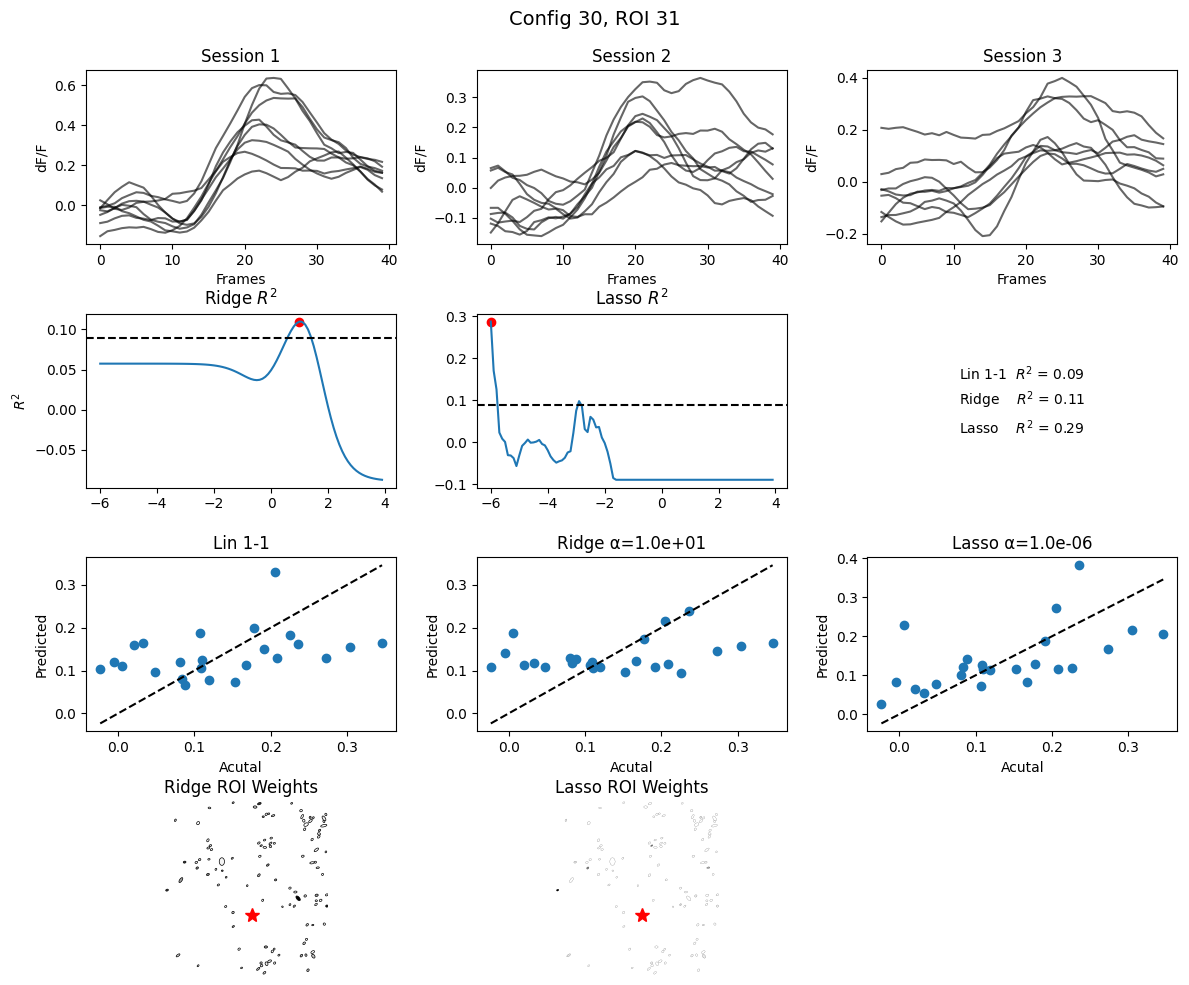

  4%|███▊                                                                                              | 1/26 [00:12<05:20, 12.81s/it]

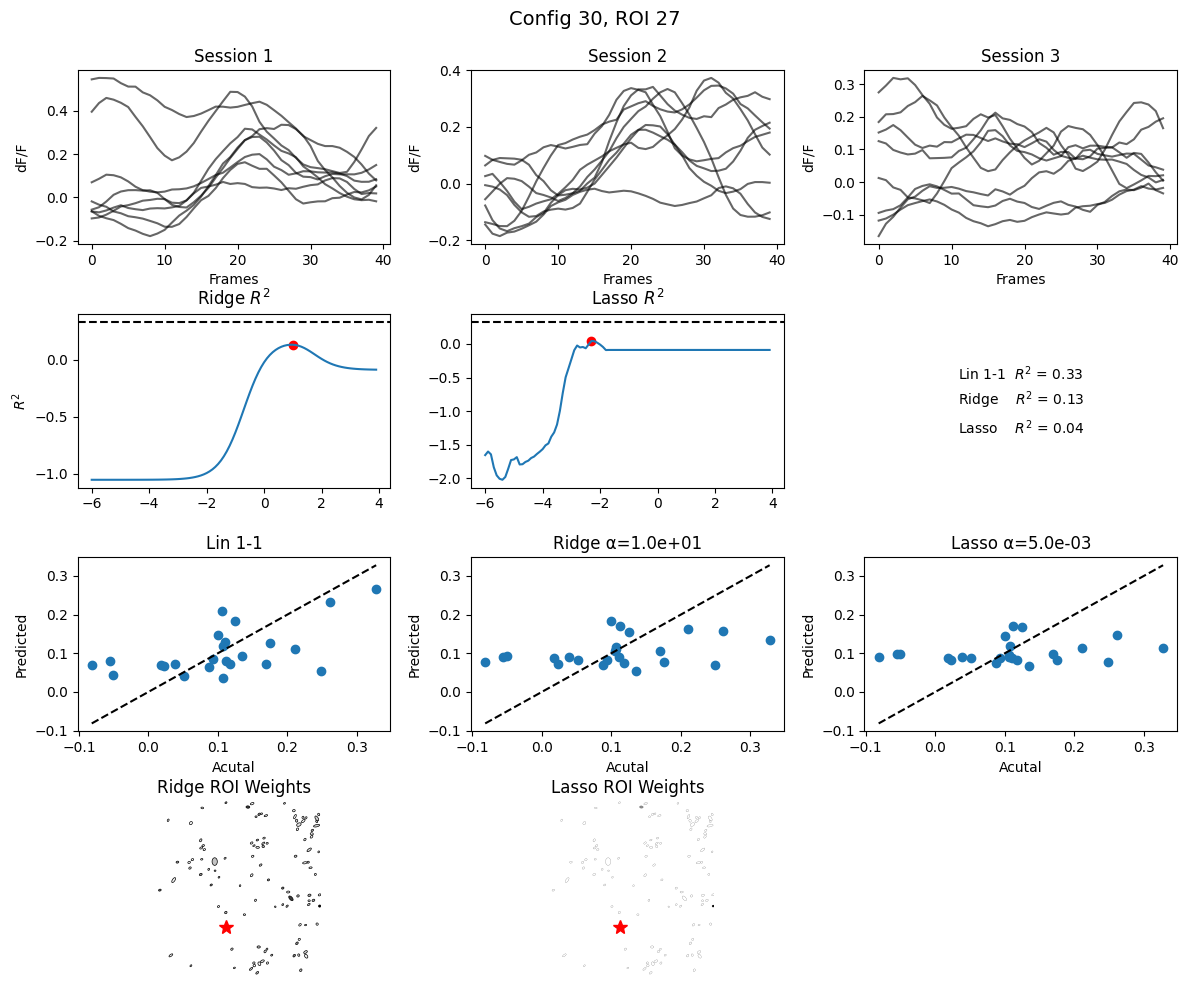

  8%|███████▌                                                                                          | 2/26 [00:30<06:20, 15.85s/it]

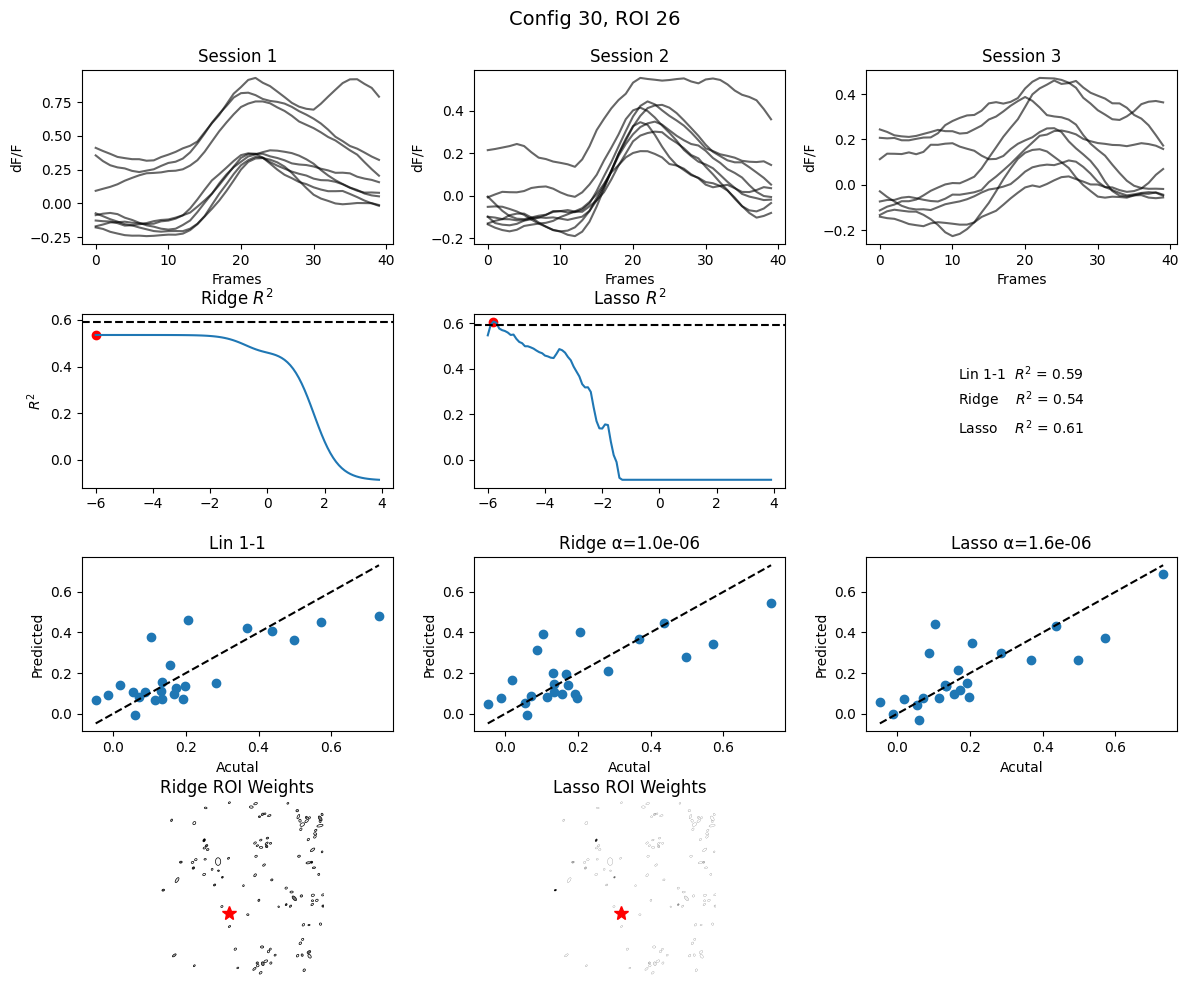

 12%|███████████▎                                                                                      | 3/26 [00:41<05:11, 13.53s/it]

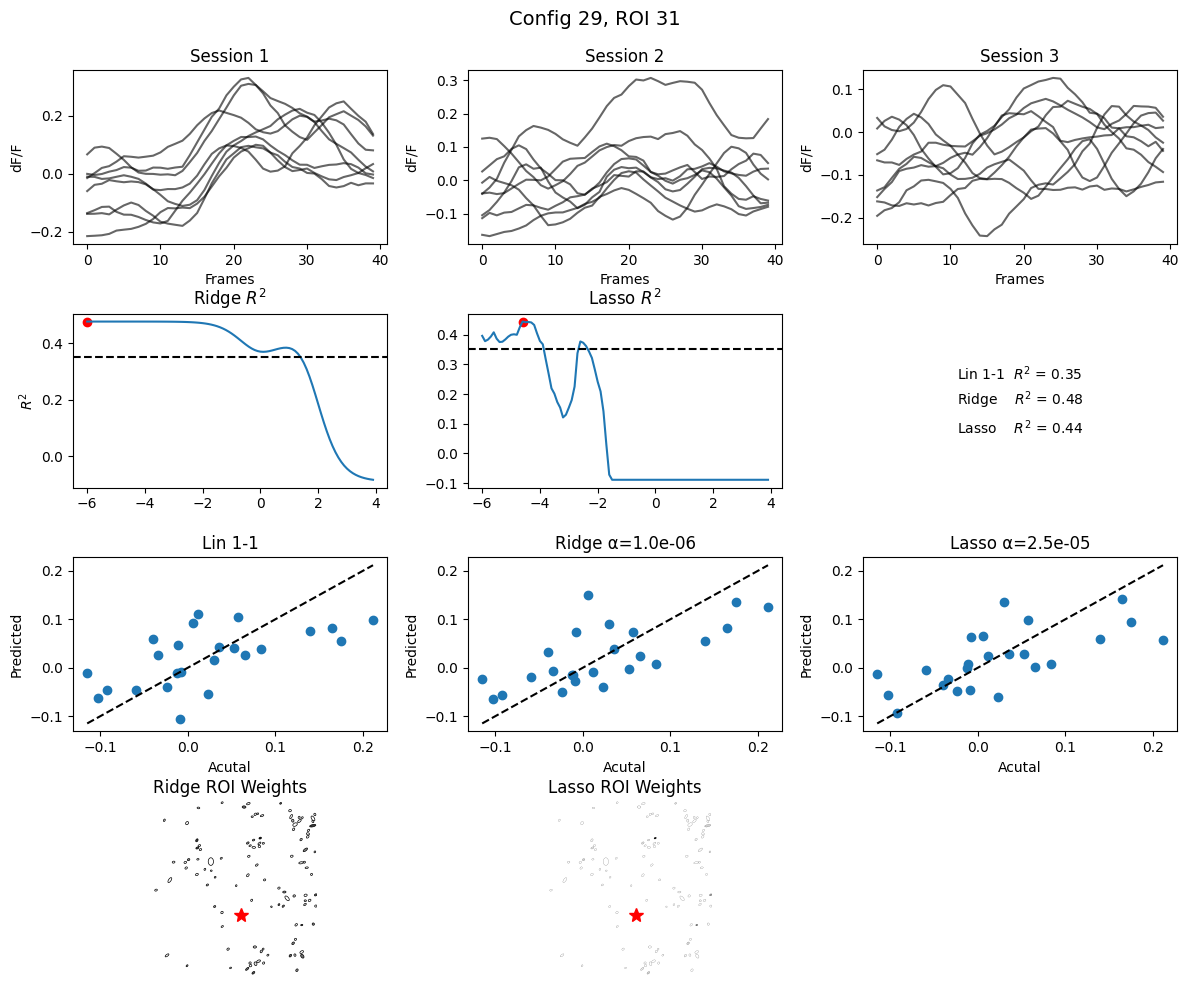

 15%|███████████████                                                                                   | 4/26 [01:00<05:47, 15.81s/it]

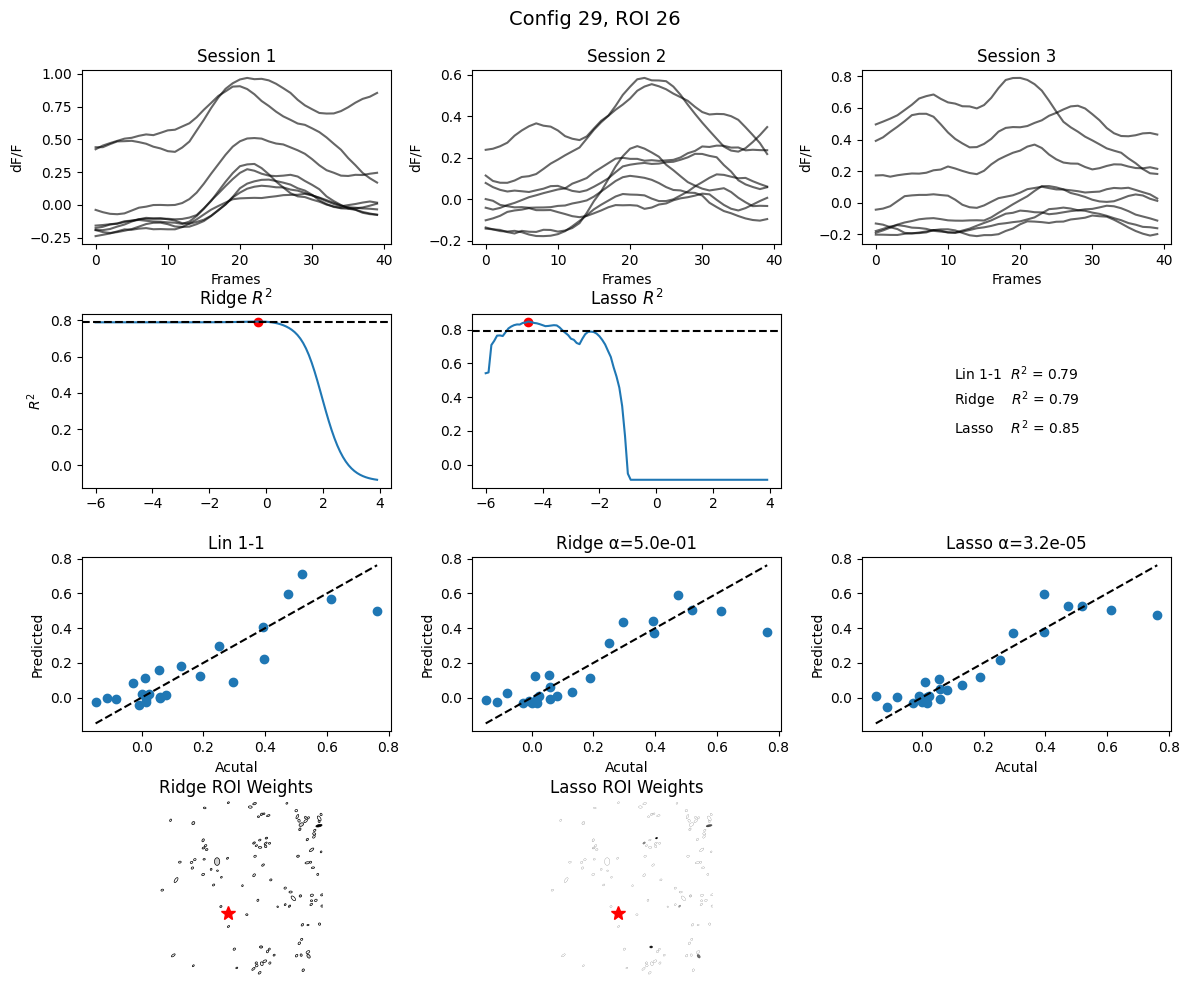

 19%|██████████████████▊                                                                               | 5/26 [01:18<05:48, 16.58s/it]

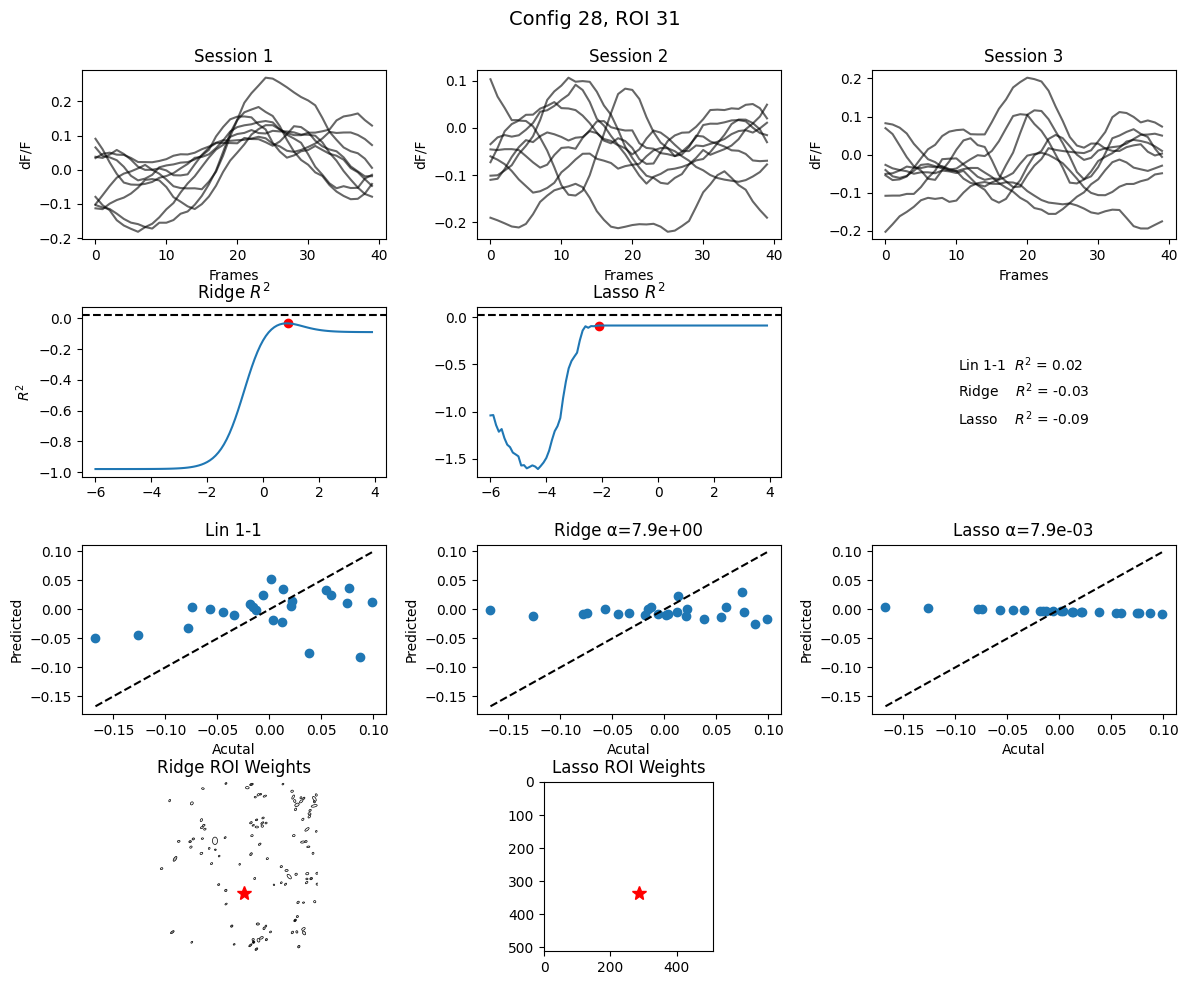

 23%|██████████████████████▌                                                                           | 6/26 [01:28<04:45, 14.27s/it]

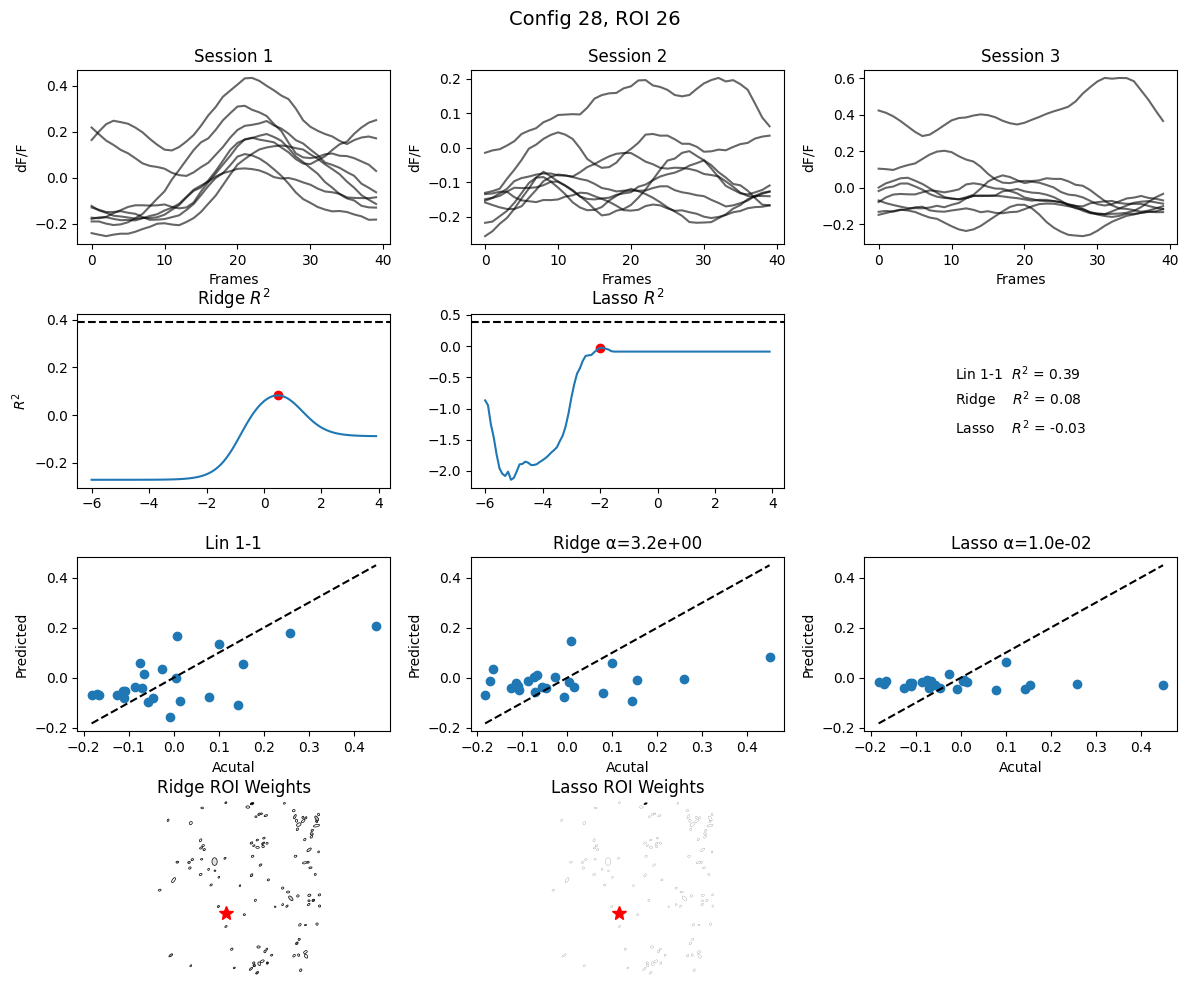

 27%|██████████████████████████▍                                                                       | 7/26 [01:44<04:39, 14.72s/it]

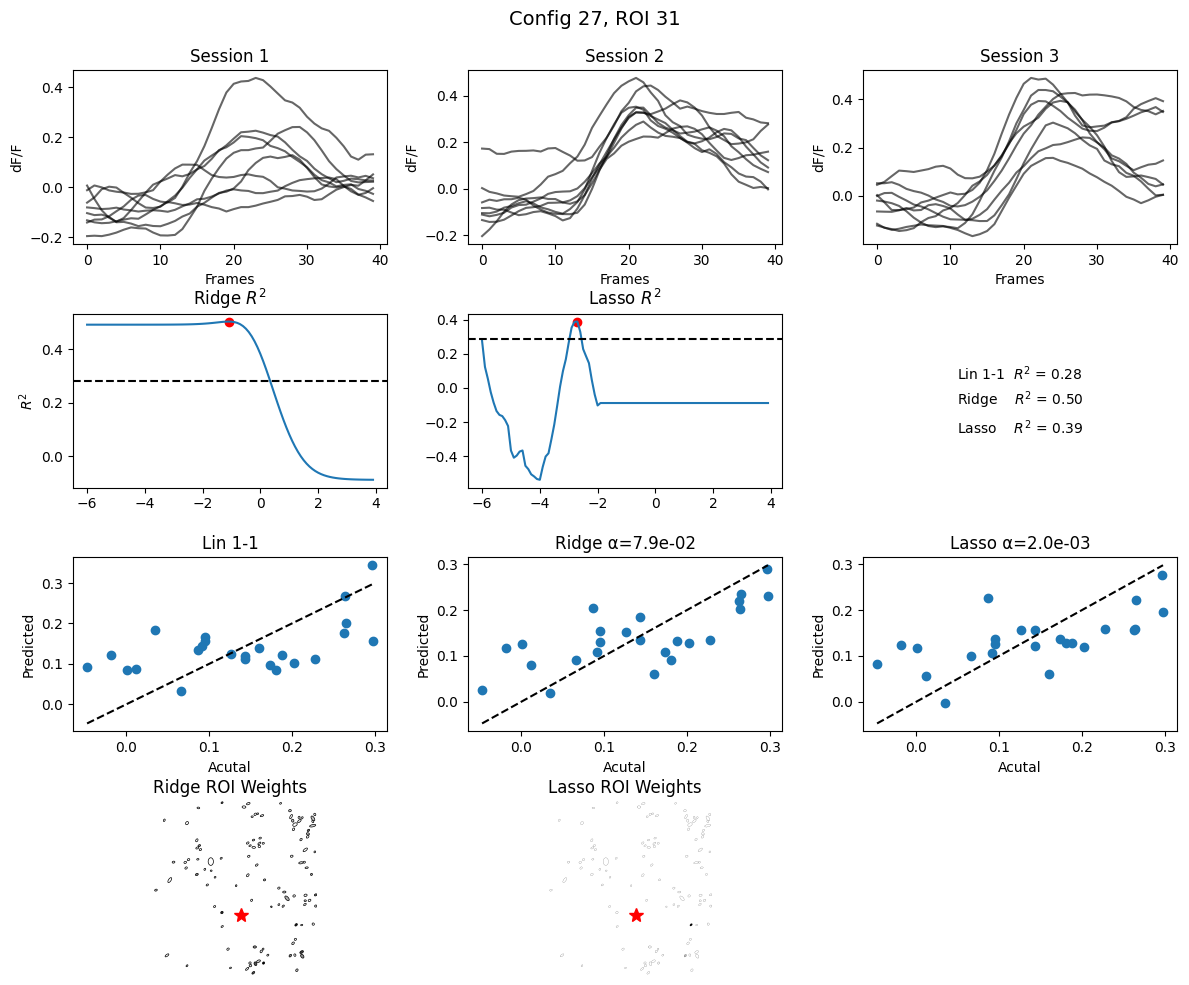

 31%|██████████████████████████████▏                                                                   | 8/26 [01:55<04:07, 13.74s/it]

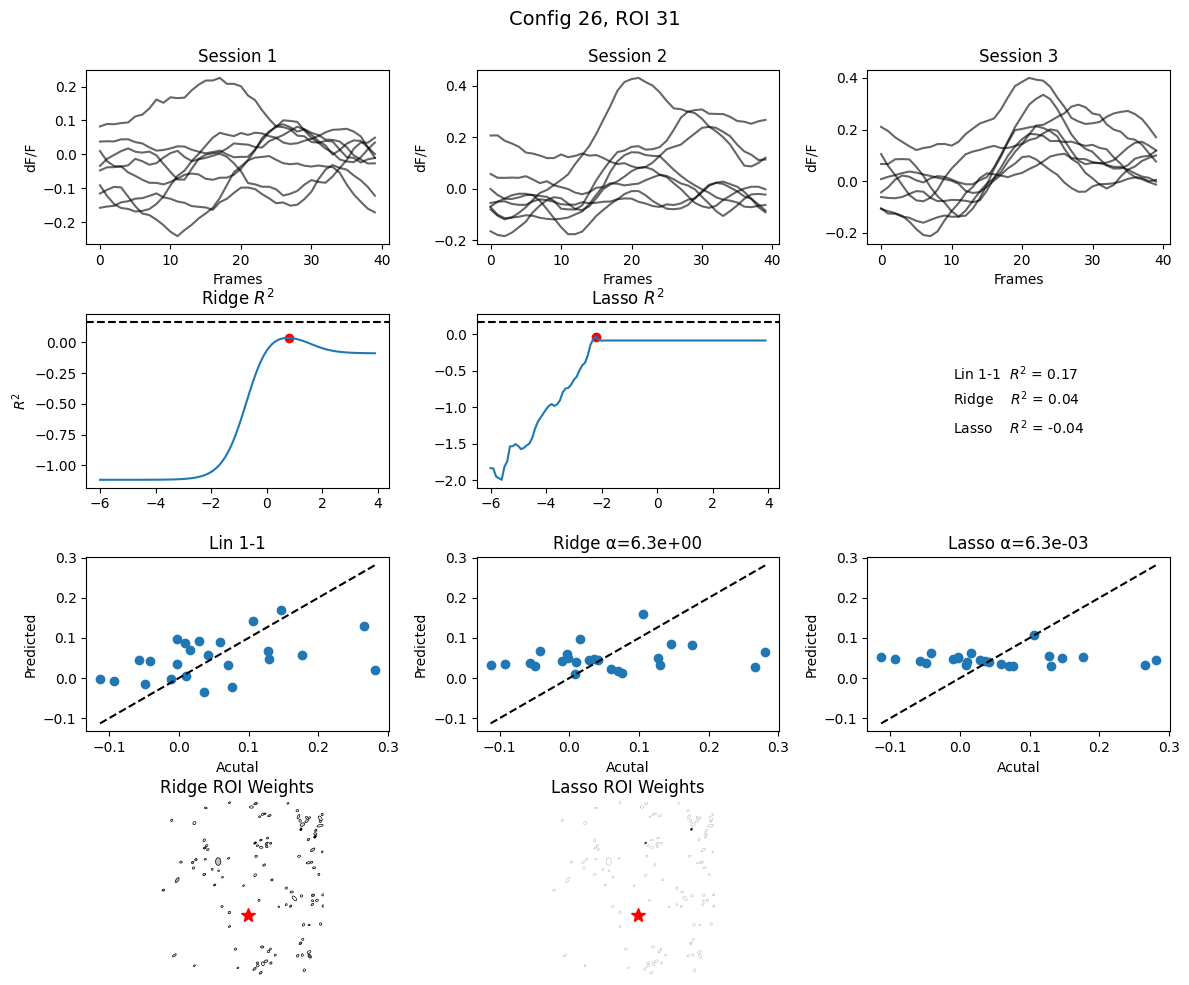

 35%|█████████████████████████████████▉                                                                | 9/26 [02:12<04:10, 14.76s/it]

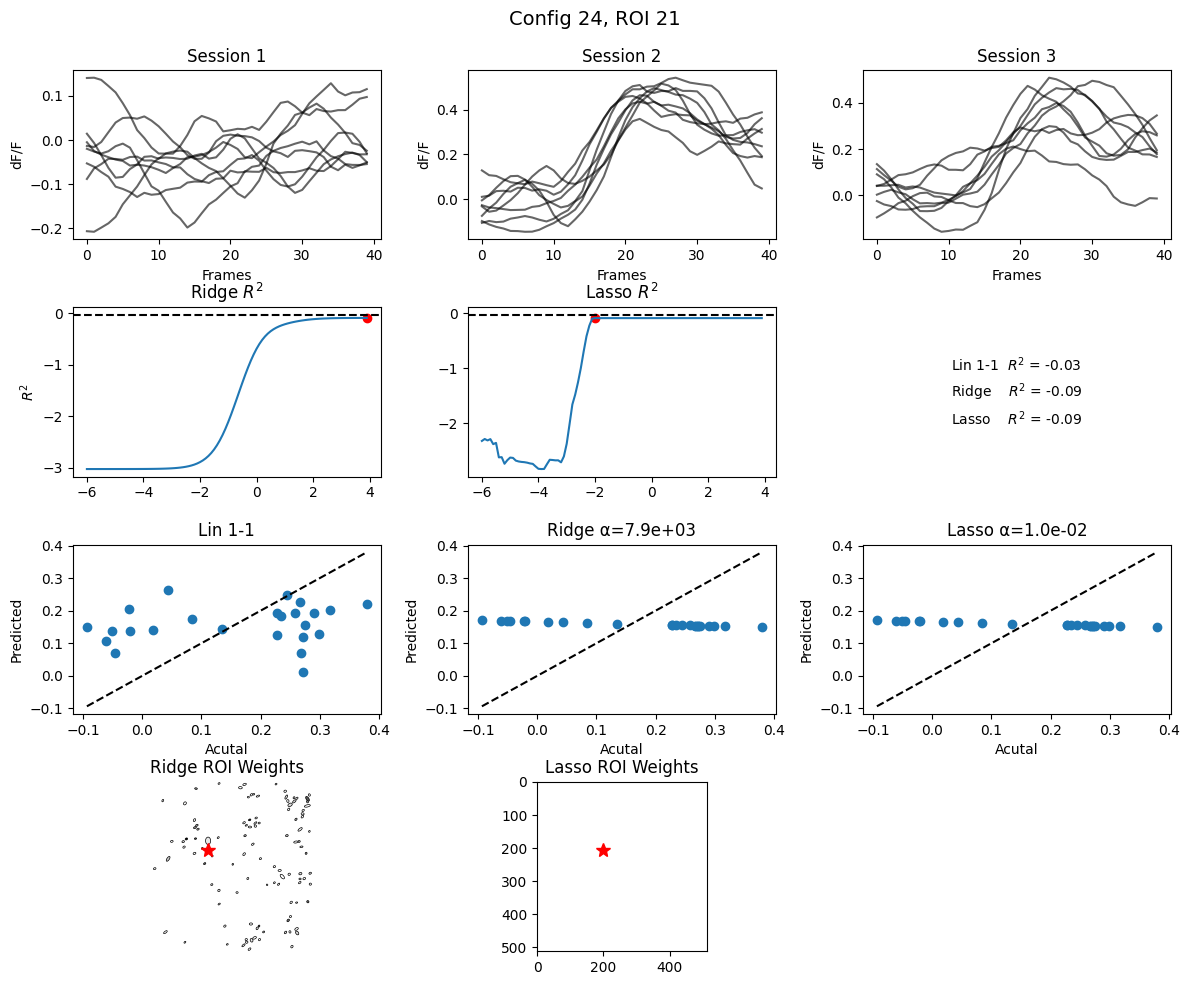

 38%|█████████████████████████████████████▎                                                           | 10/26 [02:34<04:32, 17.00s/it]

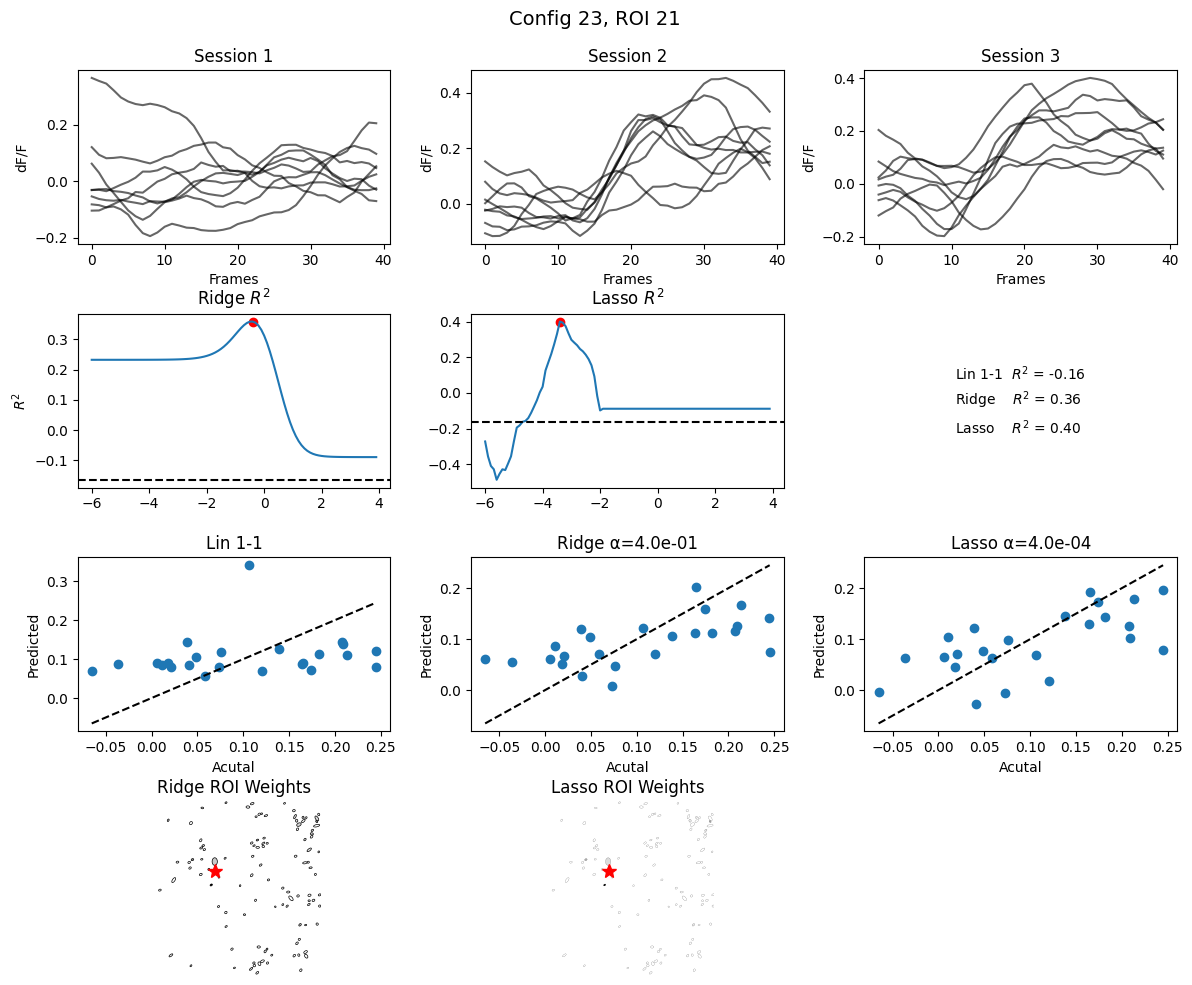

 42%|█████████████████████████████████████████                                                        | 11/26 [02:47<03:53, 15.56s/it]

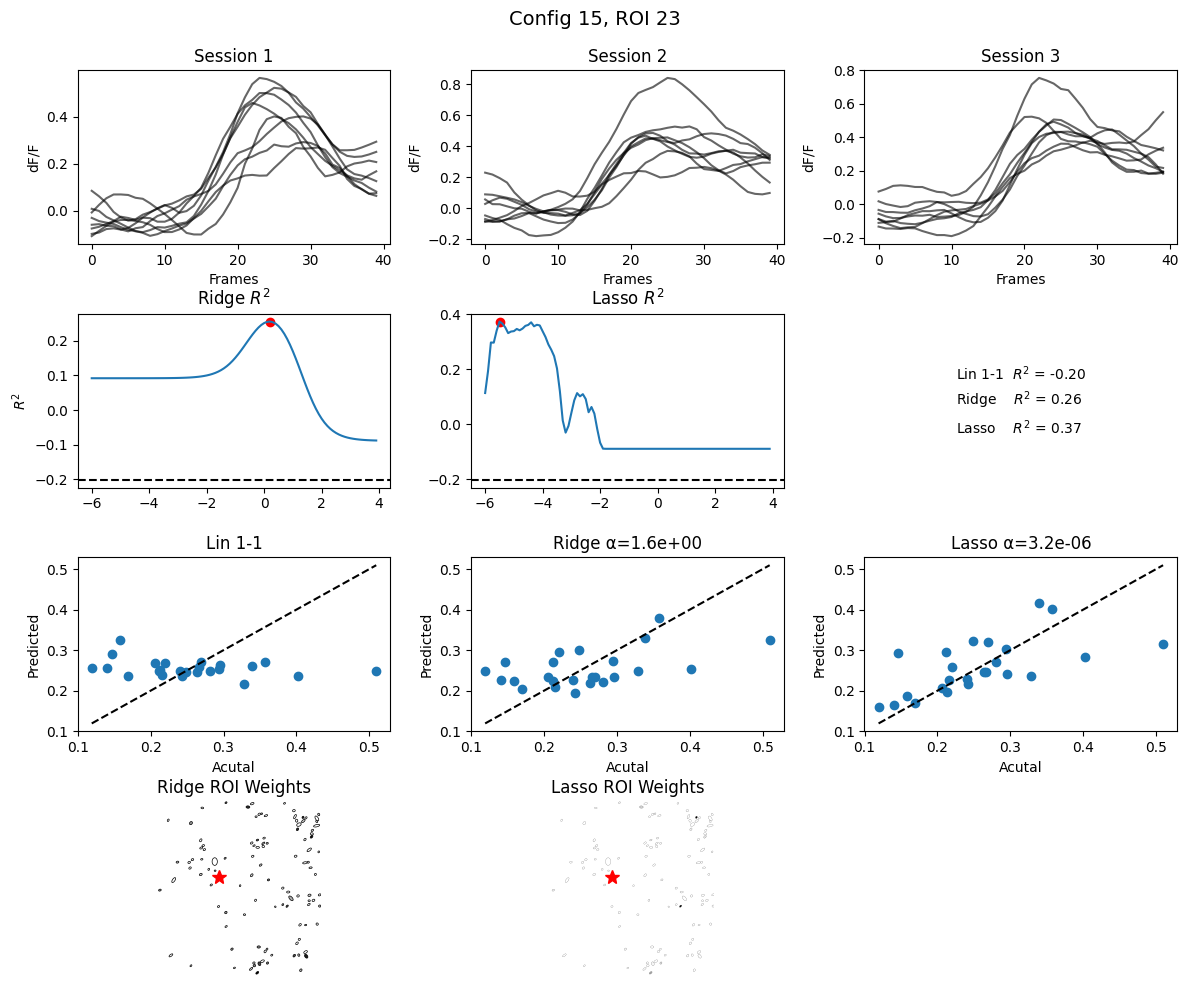

 46%|████████████████████████████████████████████▊                                                    | 12/26 [03:03<03:39, 15.69s/it]

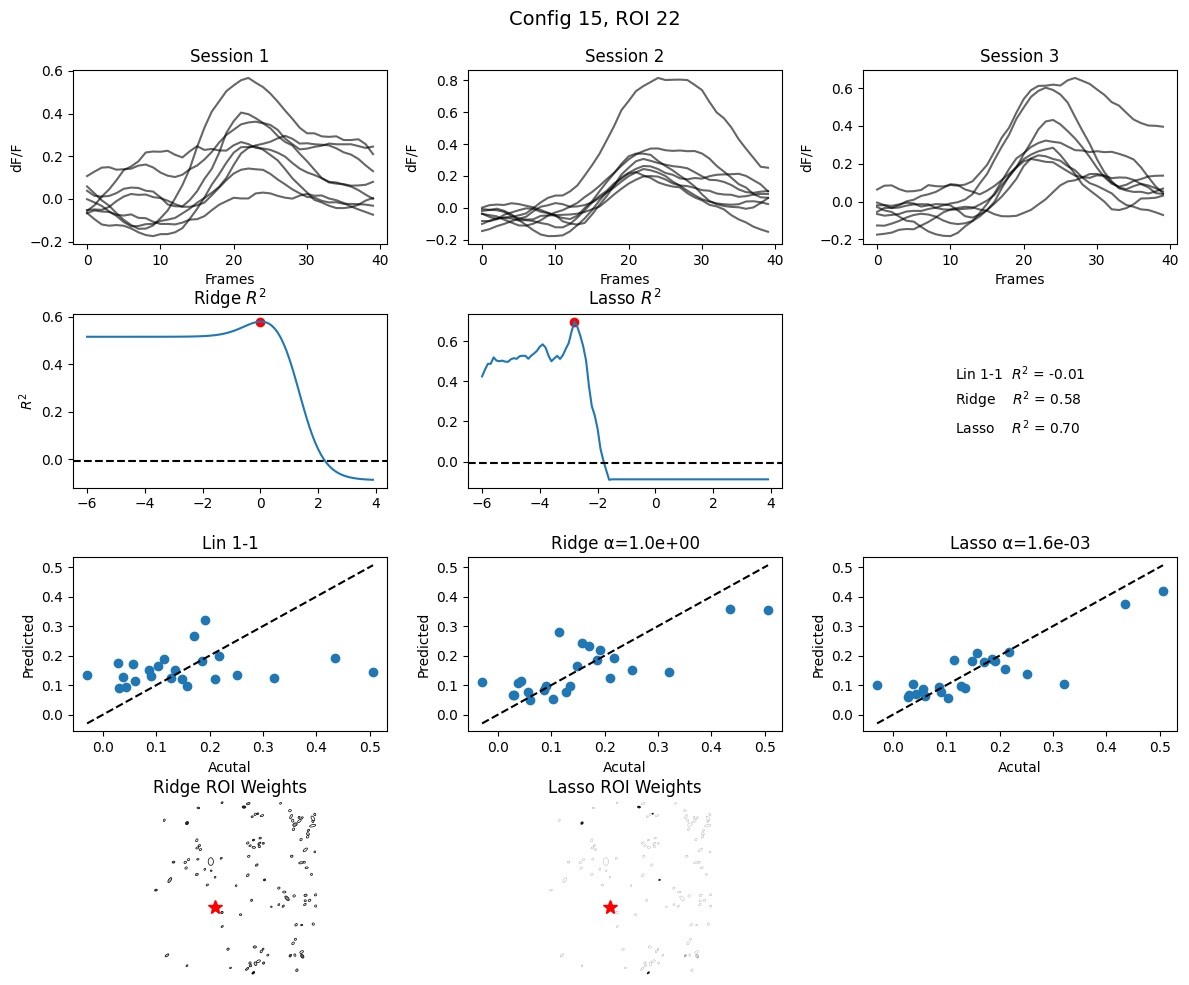

 50%|████████████████████████████████████████████████▌                                                | 13/26 [03:15<03:11, 14.69s/it]

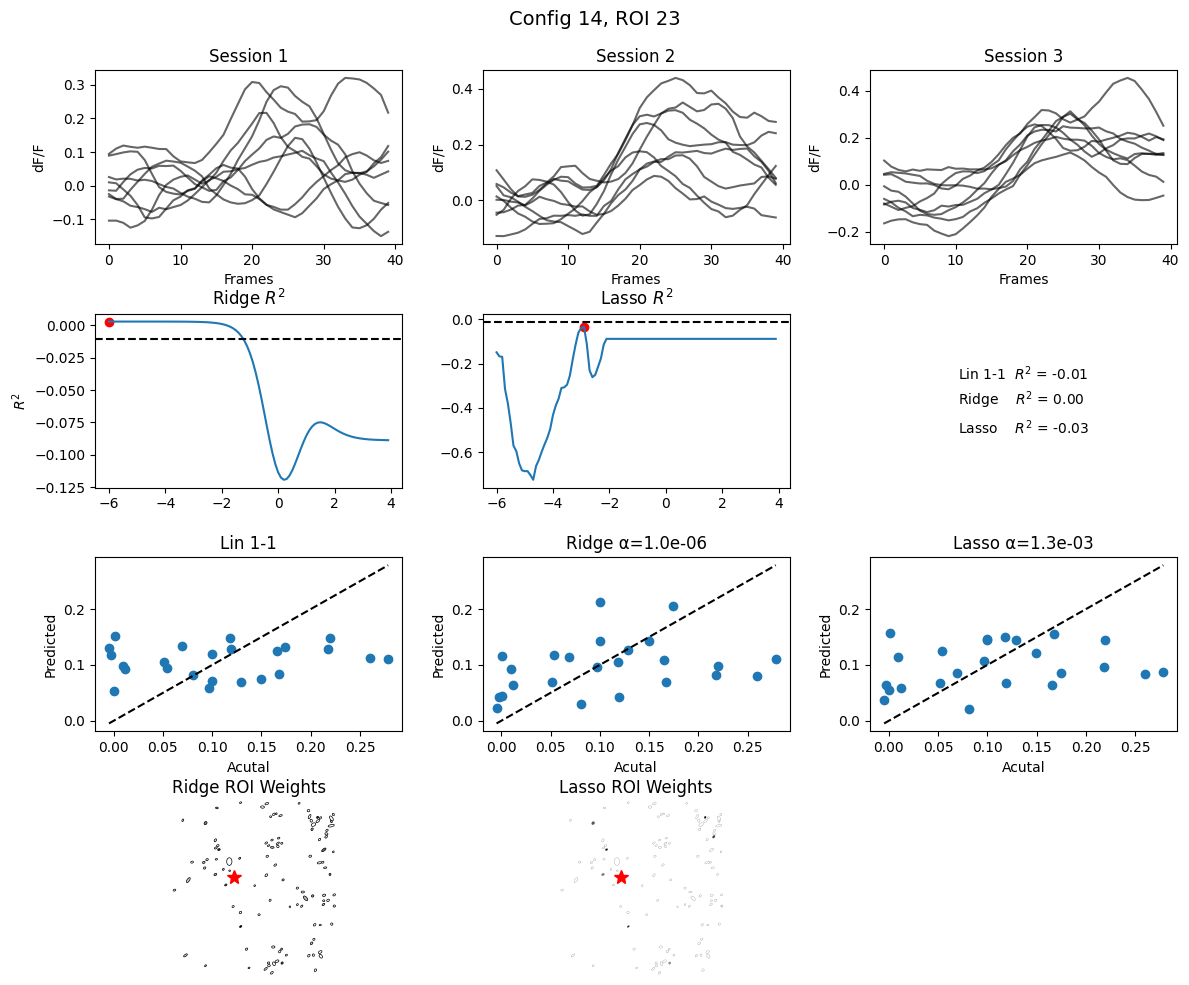

 54%|████████████████████████████████████████████████████▏                                            | 14/26 [03:24<02:36, 13.05s/it]

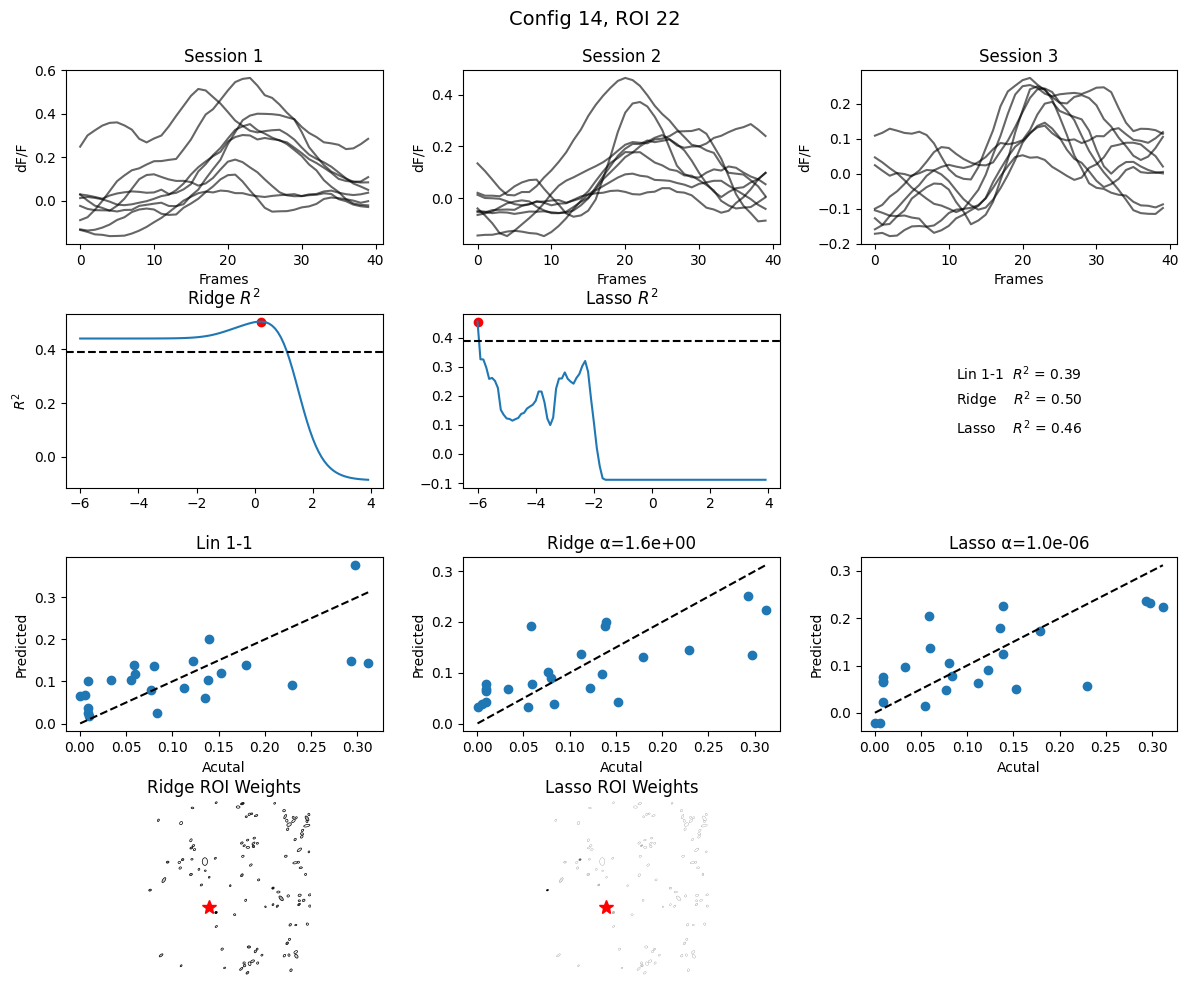

 58%|███████████████████████████████████████████████████████▉                                         | 15/26 [03:35<02:16, 12.39s/it]

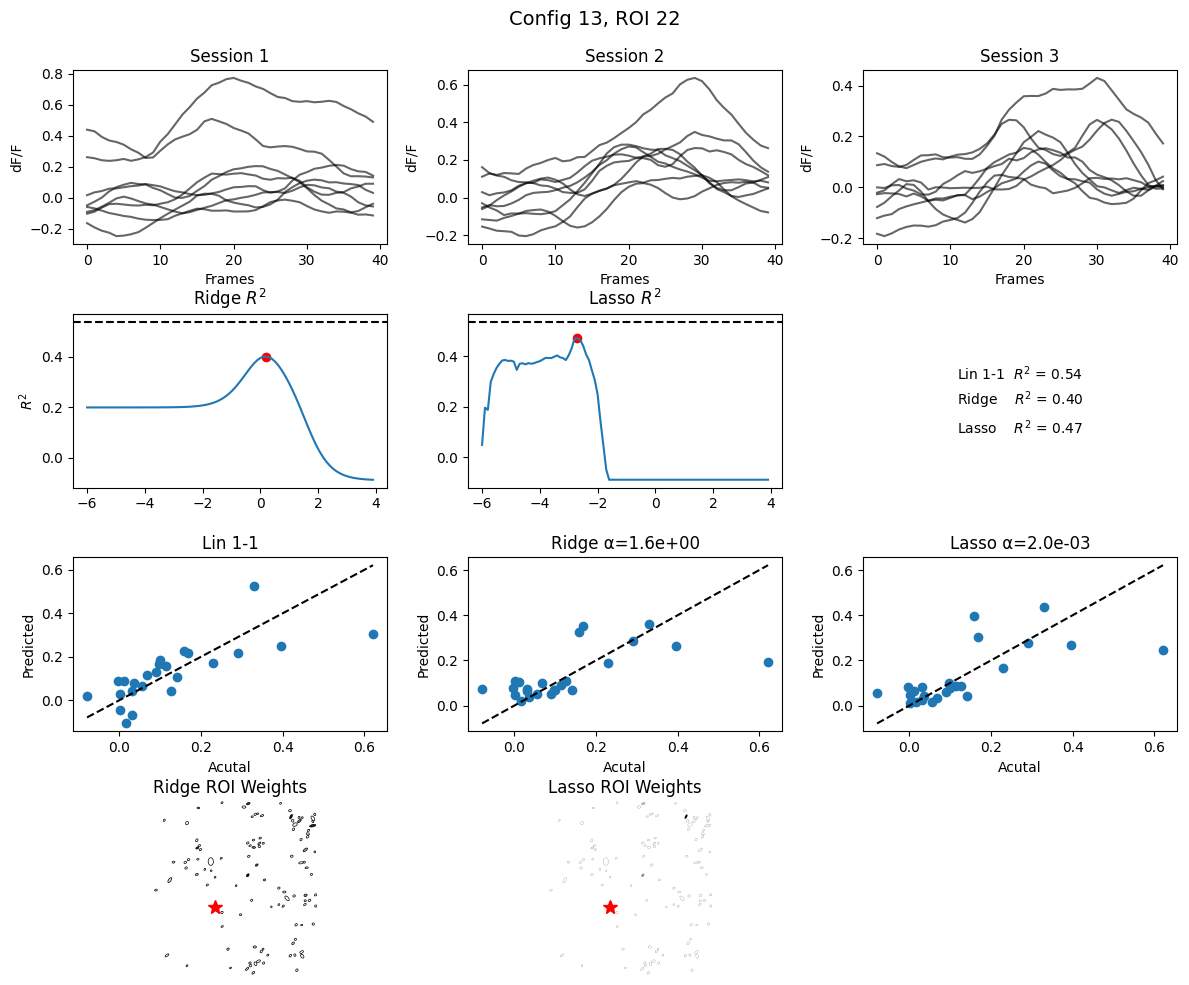

 62%|███████████████████████████████████████████████████████████▋                                     | 16/26 [03:51<02:14, 13.44s/it]

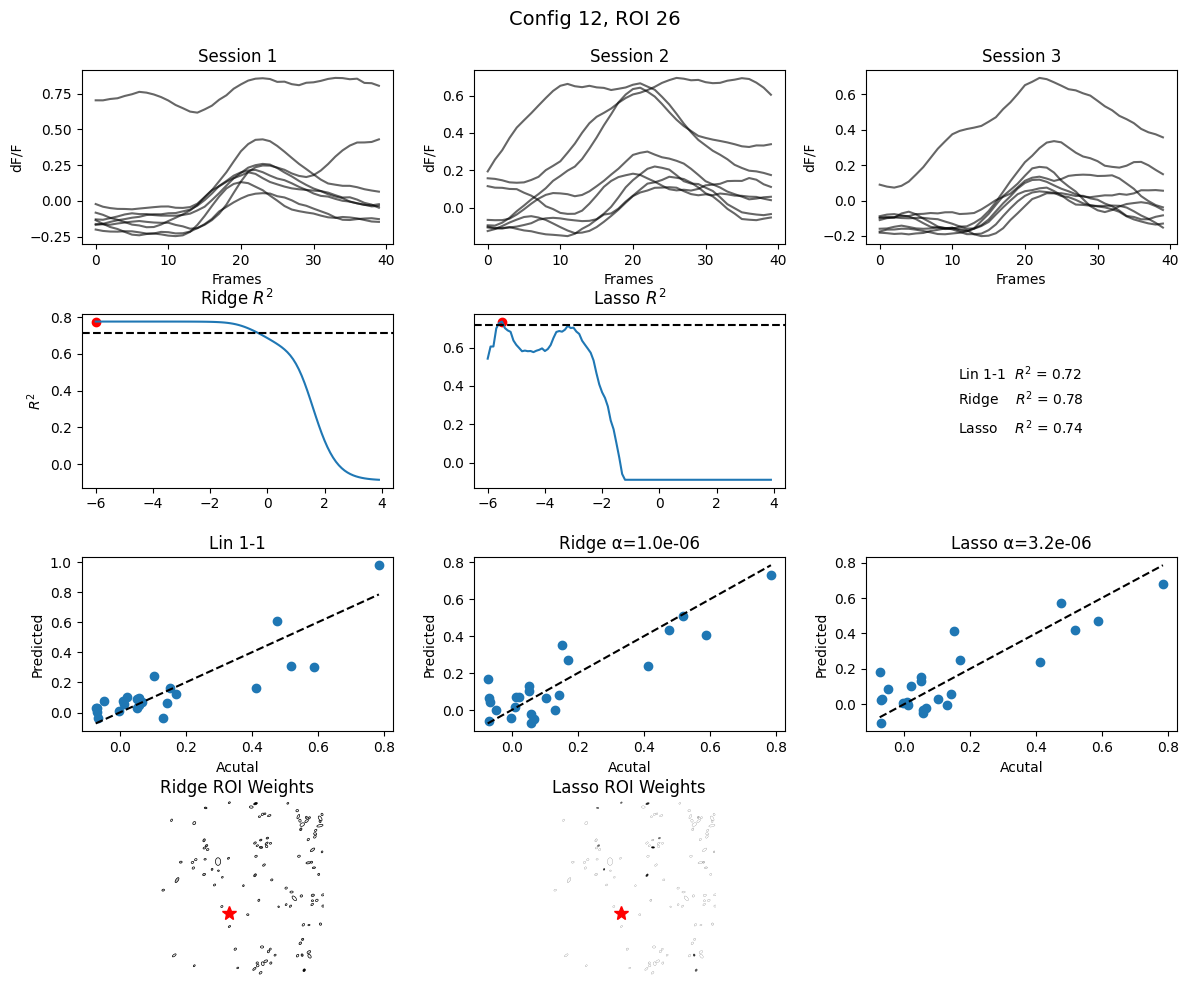

 65%|███████████████████████████████████████████████████████████████▍                                 | 17/26 [04:10<02:16, 15.17s/it]

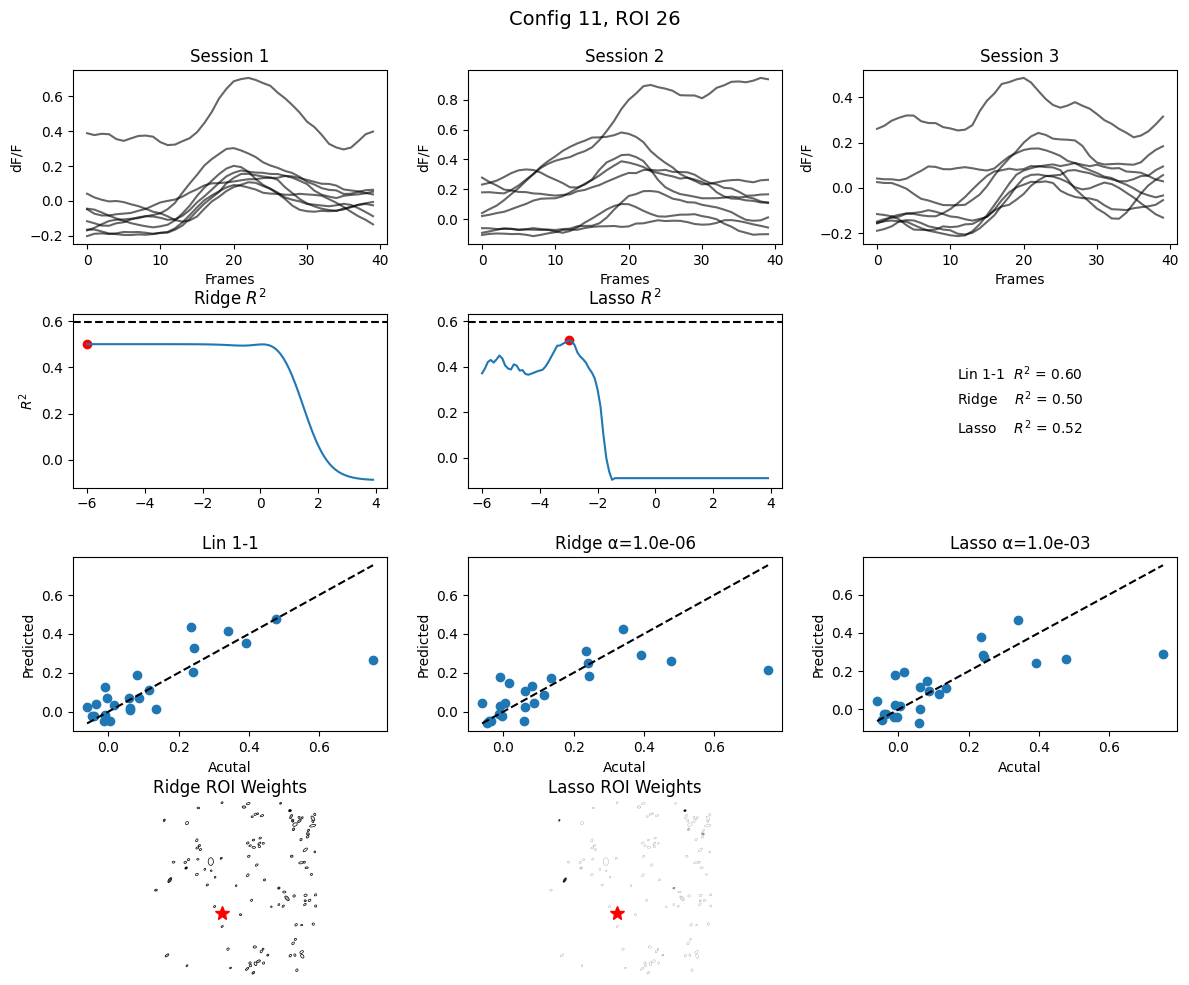

 69%|███████████████████████████████████████████████████████████████████▏                             | 18/26 [04:20<01:48, 13.62s/it]

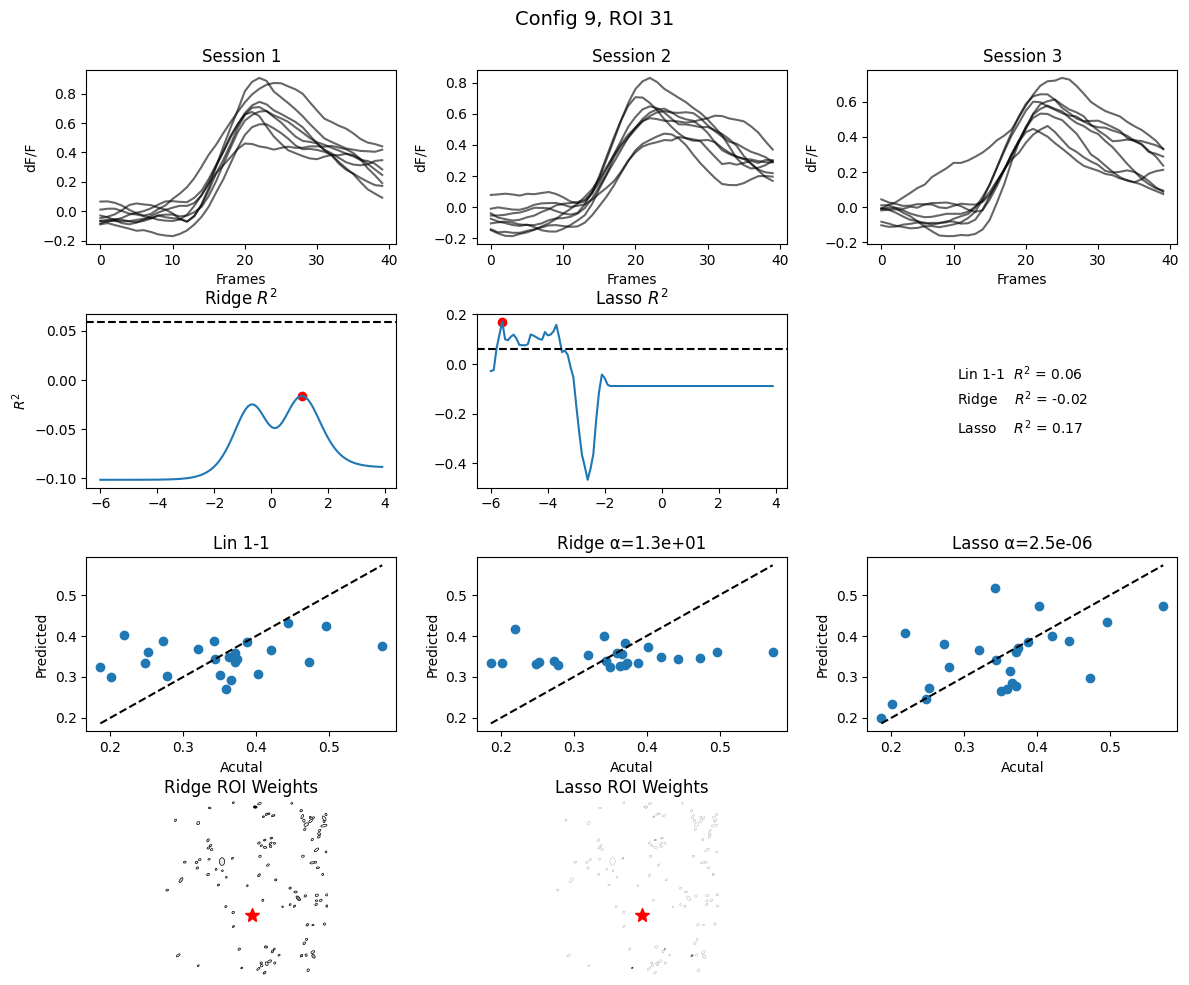

 73%|██████████████████████████████████████████████████████████████████████▉                          | 19/26 [04:32<01:32, 13.17s/it]

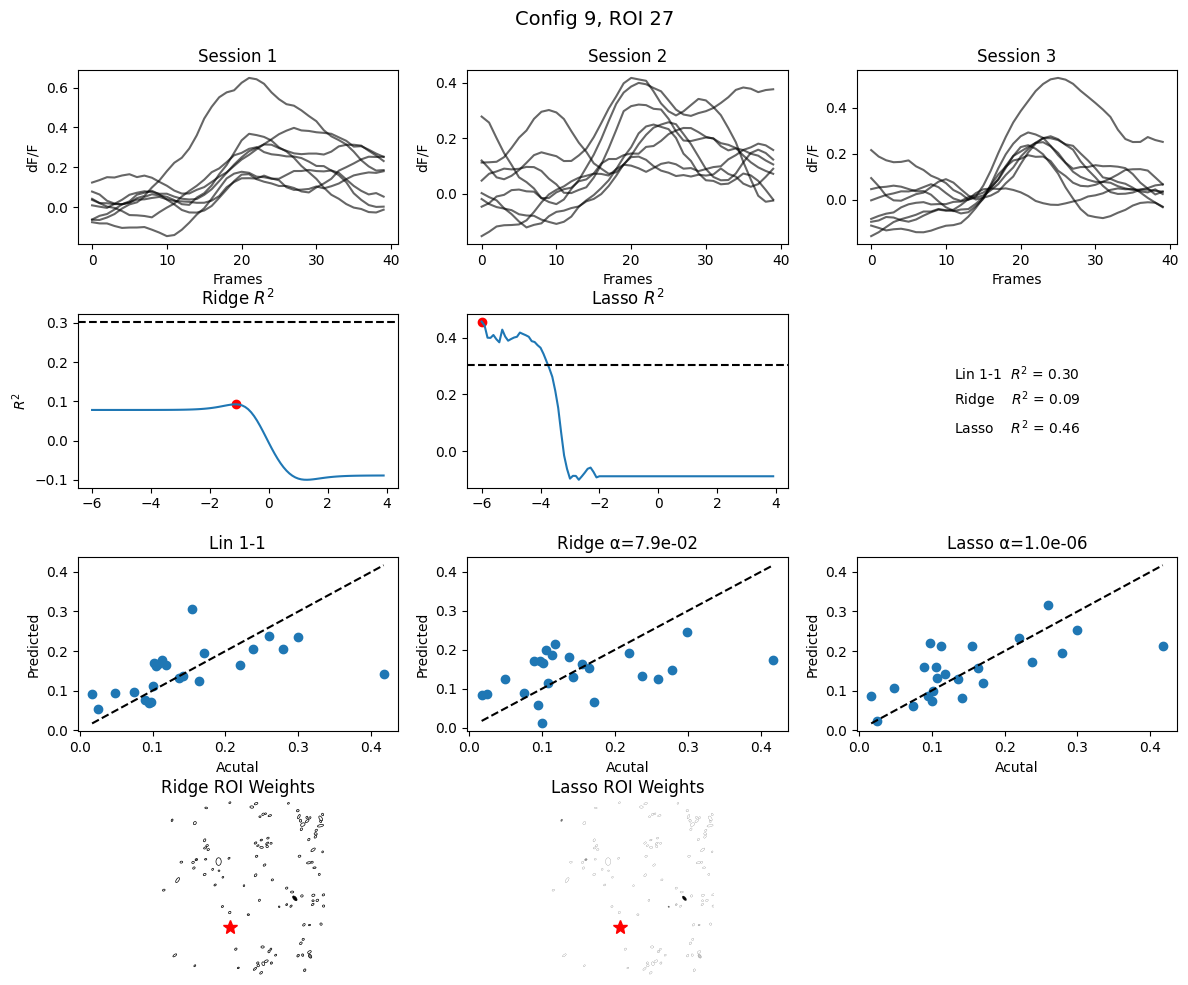

 77%|██████████████████████████████████████████████████████████████████████████▌                      | 20/26 [04:44<01:15, 12.61s/it]

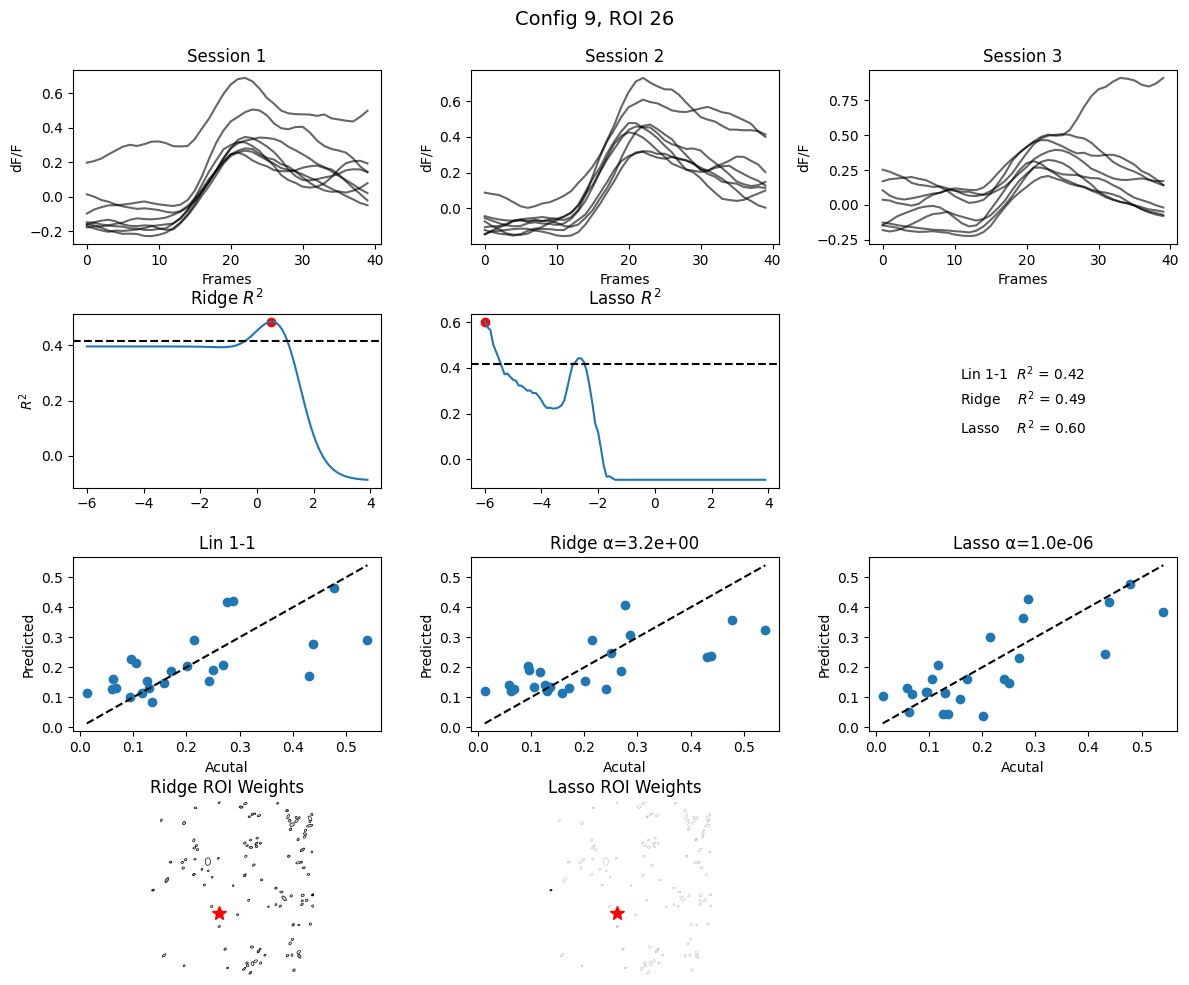

 81%|██████████████████████████████████████████████████████████████████████████████▎                  | 21/26 [04:54<00:59, 11.84s/it]

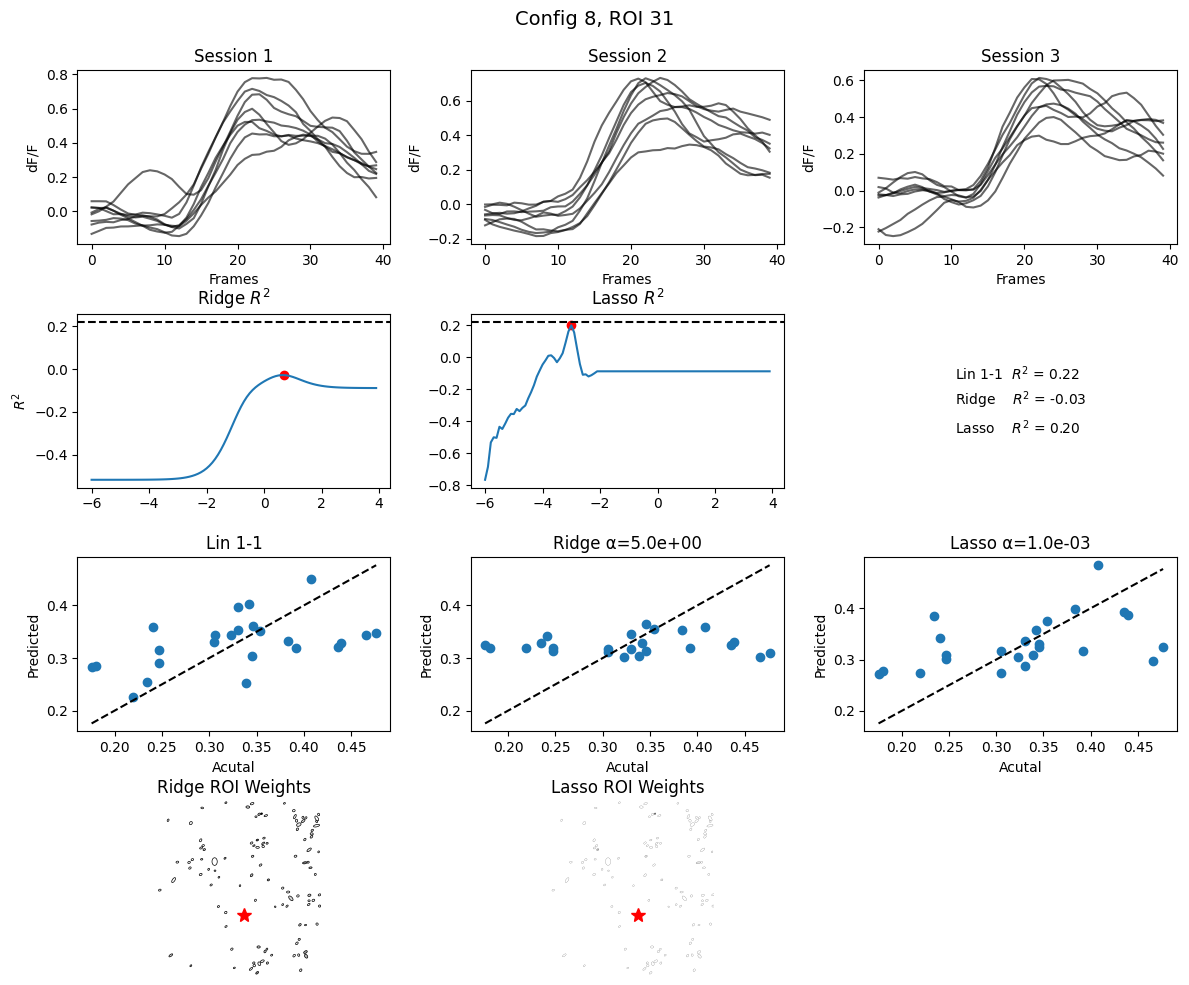

 85%|██████████████████████████████████████████████████████████████████████████████████               | 22/26 [05:07<00:48, 12.14s/it]

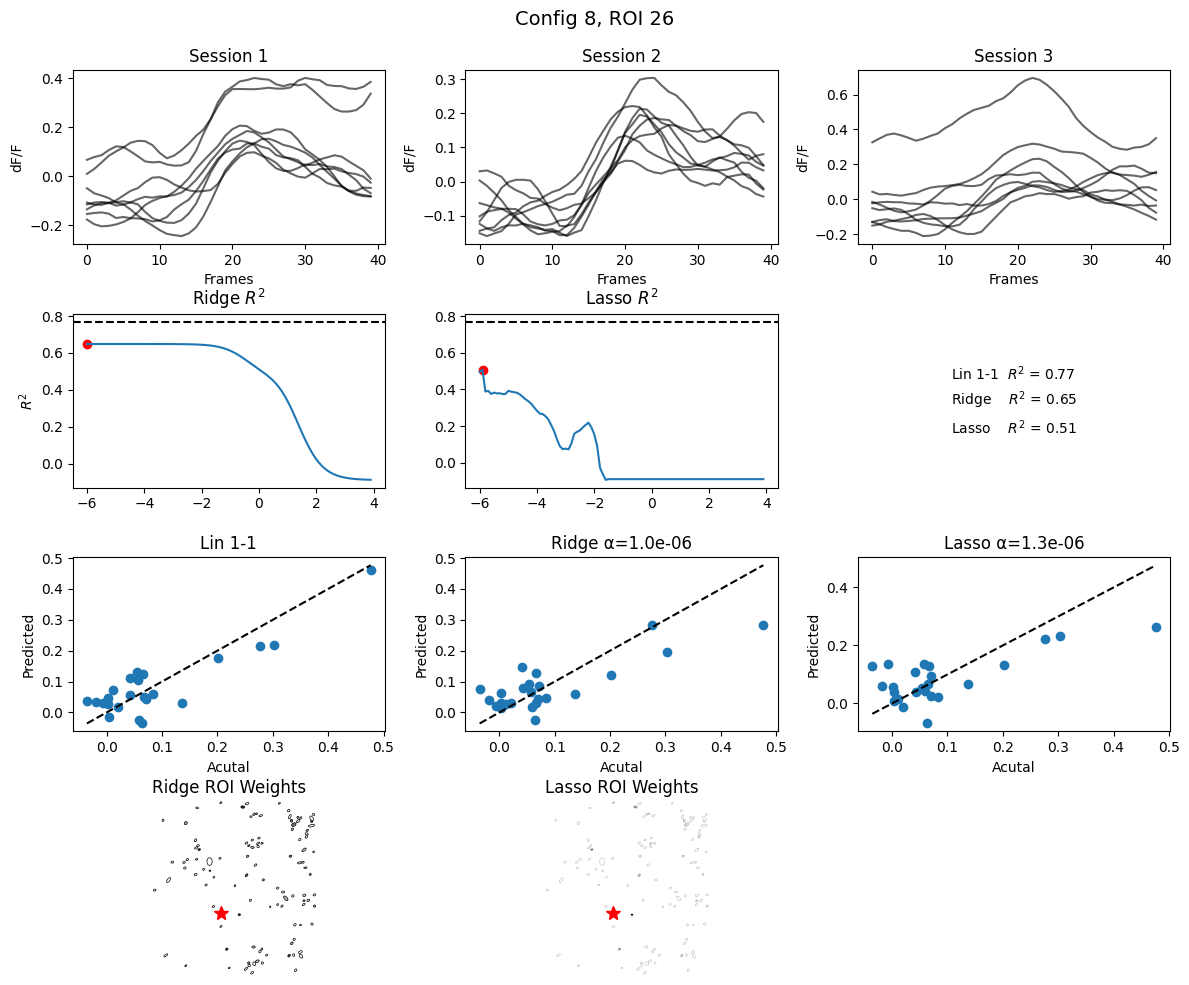

 88%|█████████████████████████████████████████████████████████████████████████████████████▊           | 23/26 [05:19<00:36, 12.14s/it]

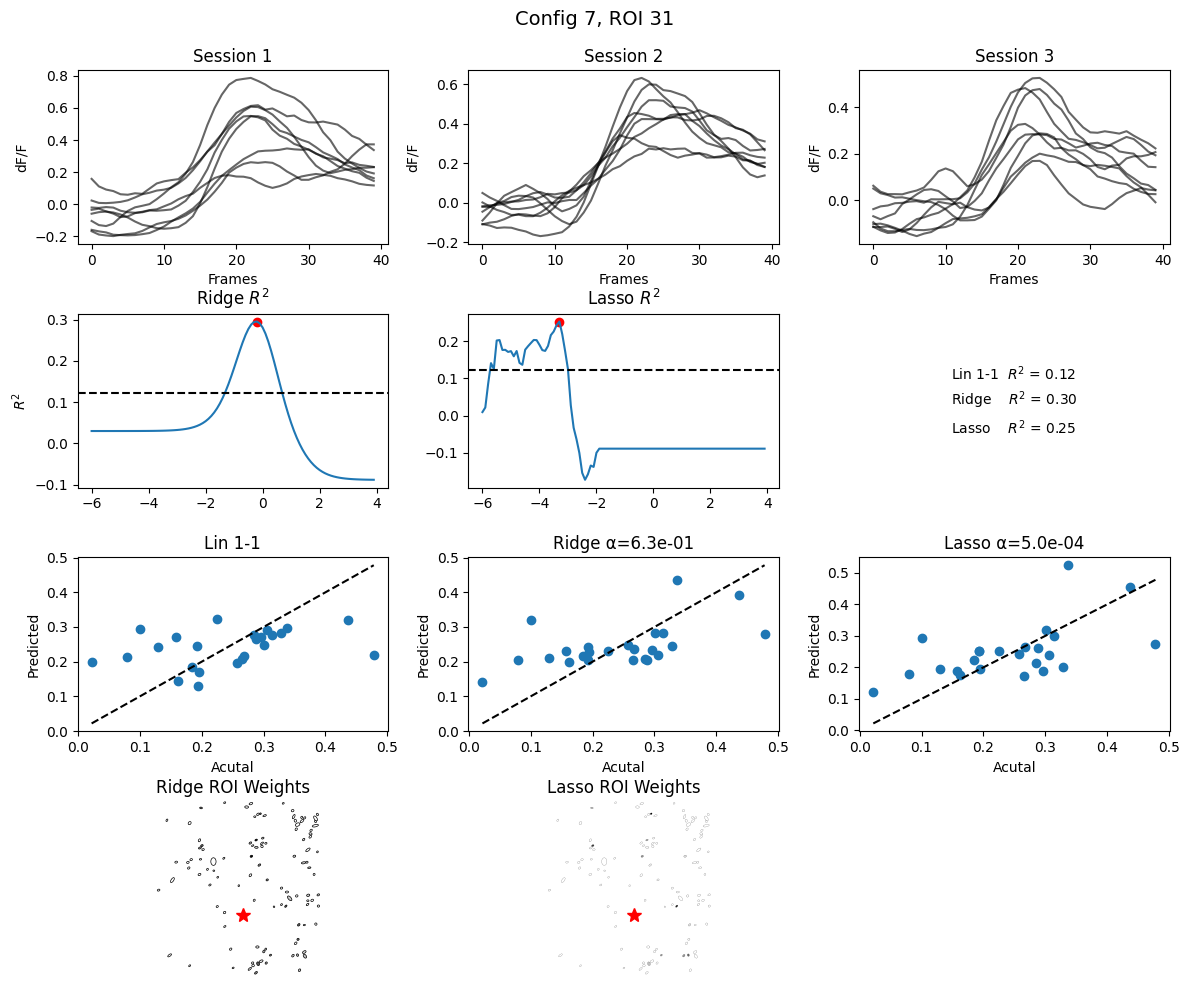

 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 24/26 [05:29<00:23, 11.51s/it]

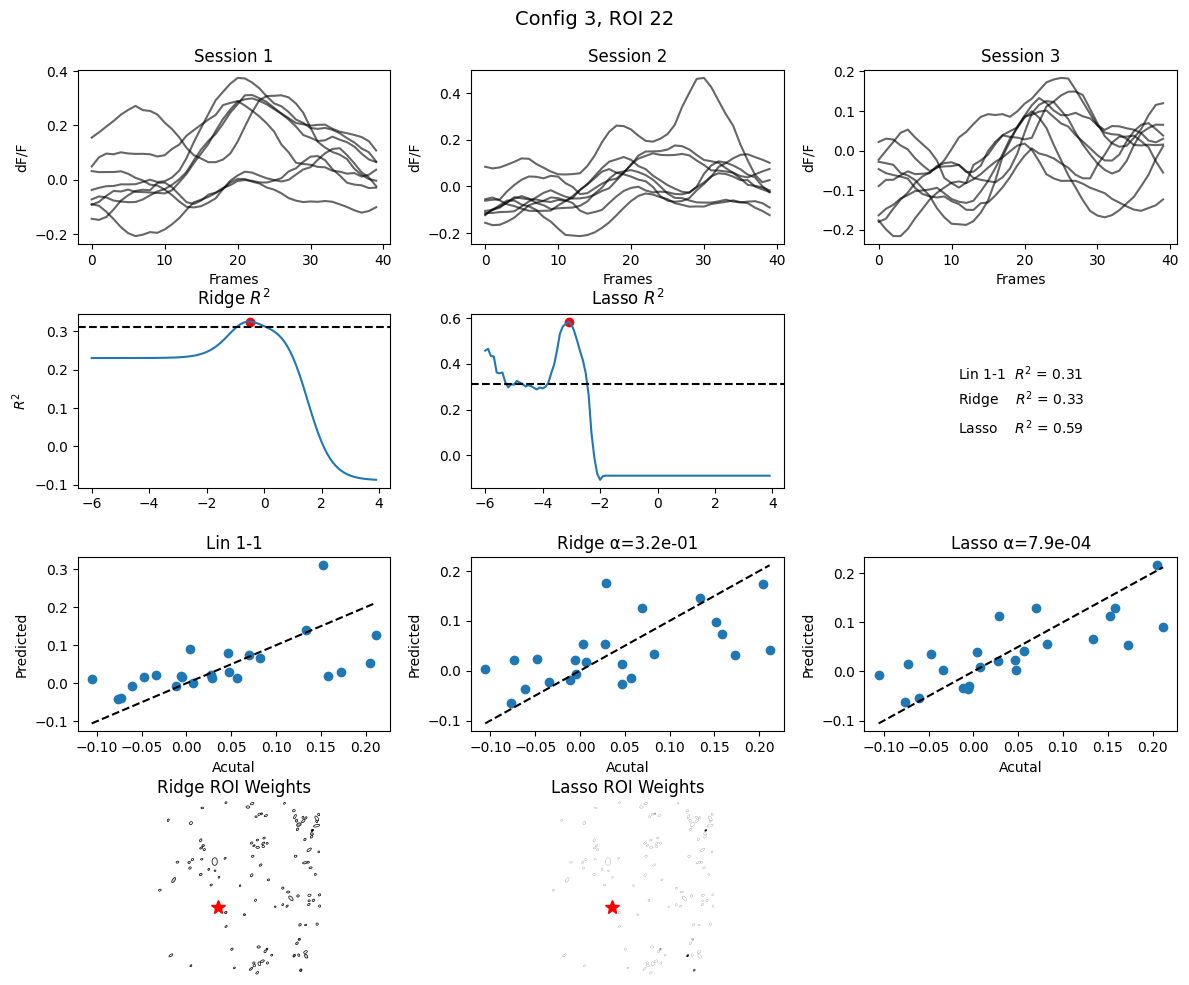

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 25/26 [05:40<00:11, 11.33s/it]

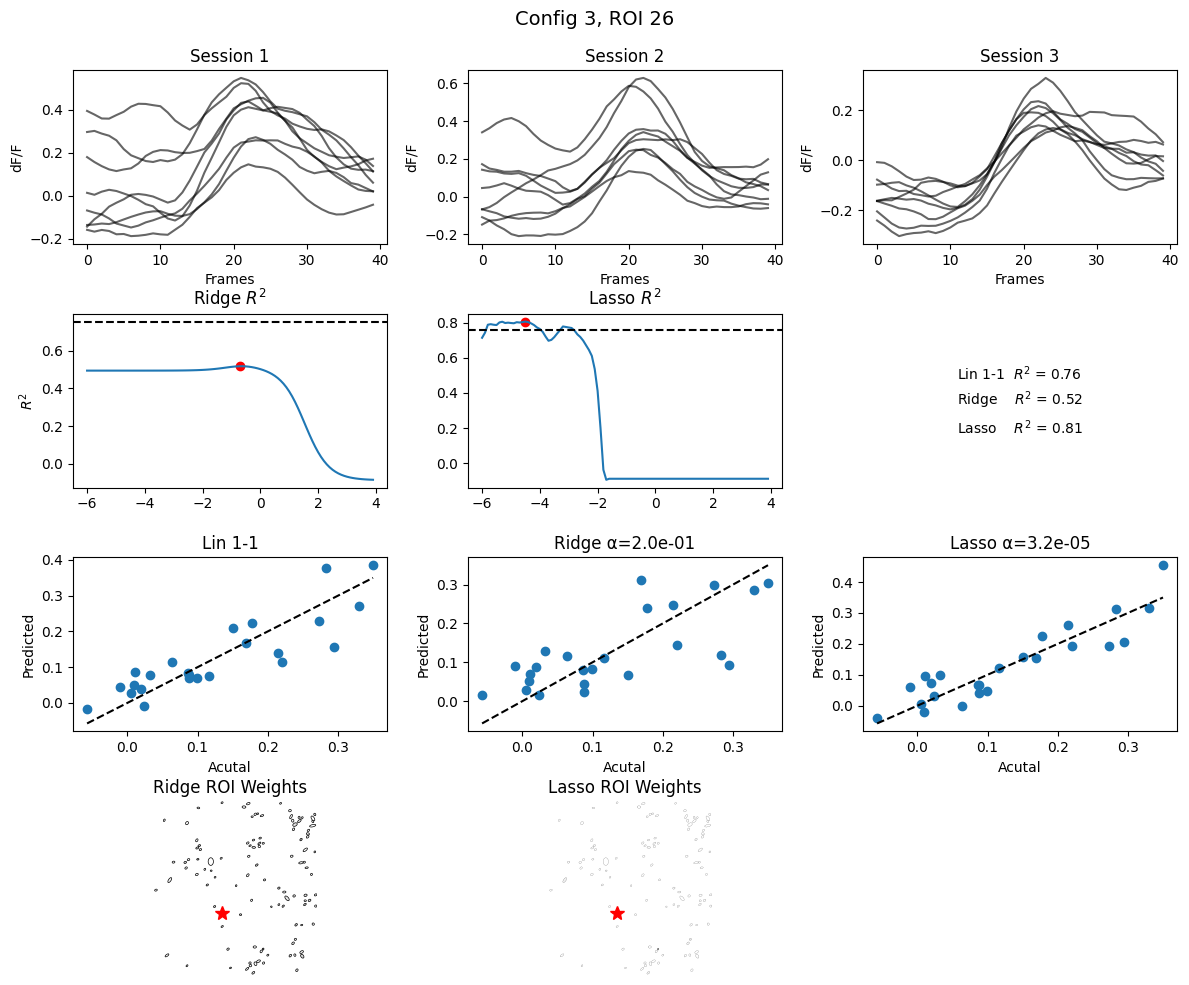

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [05:50<00:00, 13.48s/it]


In [6]:
import tqdm 
from tqdm import tqdm
for config, roi in tqdm(good_pairs[::-1]):
    plot_summary_figure(config, roi, roi_mask)
    plt.savefig(f'/Users/bhaishahster/Data/xie_lab/code/figures/pre_post_roi:{roi}, config:{config}.pdf')
    plt.show()

In [7]:
lin11_log = []
ridge_all1_log = []
lasso_all1_log = []

import tqdm 
from tqdm import tqdm
for config, roi in tqdm(good_pairs):
    _, r2_lin, _ = get_best_model_nps(LinearRegression, config, roi, 'pre-post', [None], 
                                   False, False)
    _, r2_ridge, _ = get_best_model_nps(Ridge, config, roi, 'pre-post', 
                                     np.power(10, np.arange(-6, 3, 0.1)),
                                     False)
    _, r2_lasso, _ = get_best_model_nps(Lasso, config, roi, 'pre-post', 
                                                   np.power(10, np.arange(-6, 3, 0.1)), #[0.001,0.01,0.001], 
                                                   False)

    print('models', r2_lin, r2_ridge, r2_lasso)
    lin11_log += [r2_lin]
    ridge_all1_log += [r2_ridge]
    lasso_all1_log += [r2_lasso]
    
    
results.update({'pre-post': {'lin11': lin11_log, 
                             'ridge_all1': ridge_all1_log, 
                             'lasso_all1': lasso_all1_log}})


  4%|███▊                                                                                              | 1/26 [00:09<03:49,  9.17s/it]

models 0.7564583361002452 0.5184813751012568 0.8065505778469138


  8%|███████▌                                                                                          | 2/26 [00:18<03:46,  9.45s/it]

models 0.311390609388146 0.32564487892876837 0.585694071271333


 12%|███████████▎                                                                                      | 3/26 [00:27<03:33,  9.29s/it]

models 0.12212888208136197 0.2950285982394897 0.25322402885331297


 15%|███████████████                                                                                   | 4/26 [00:38<03:32,  9.67s/it]

models 0.7701931274208152 0.6485894575782043 0.5073409299373197


 19%|██████████████████▊                                                                               | 5/26 [00:49<03:38, 10.41s/it]

models 0.22189863350825956 -0.028345564336825335 0.1979376417615838


 23%|██████████████████████▌                                                                           | 6/26 [00:58<03:15,  9.77s/it]

models 0.416343094900929 0.48554676220664206 0.6020038396549203


 27%|██████████████████████████▍                                                                       | 7/26 [01:07<03:03,  9.63s/it]

models 0.30351536053167427 0.09253974446924651 0.4565935297551006


 31%|██████████████████████████████▏                                                                   | 8/26 [01:17<02:56,  9.80s/it]

models 0.059573480616850305 -0.0160576761812965 0.1714535765596984


 35%|█████████████████████████████████▉                                                                | 9/26 [01:26<02:41,  9.49s/it]

models 0.598084575397636 0.5002982170434899 0.515684140426705


 38%|█████████████████████████████████████▎                                                           | 10/26 [01:43<03:09, 11.84s/it]

models 0.7156157519951372 0.7763405991997883 0.7352105043765486


 42%|█████████████████████████████████████████                                                        | 11/26 [01:58<03:11, 12.77s/it]

models 0.5384282378203566 0.4003698389508048 0.47170806753005246


 46%|████████████████████████████████████████████▊                                                    | 12/26 [02:07<02:42, 11.64s/it]

models 0.38984265757223413 0.5040697673367197 0.4560080727599193


 50%|████████████████████████████████████████████████▌                                                | 13/26 [02:15<02:17, 10.60s/it]

models -0.010895865270693195 0.002899637452827175 -0.0342087989456501


 54%|████████████████████████████████████████████████████▏                                            | 14/26 [02:27<02:09, 10.80s/it]

models -0.006210458411508801 0.5788327504519984 0.6972323375123866


 58%|███████████████████████████████████████████████████████▉                                         | 15/26 [02:41<02:09, 11.77s/it]

models -0.20121716995080452 0.25533265115977843 0.3727068358751068


 62%|███████████████████████████████████████████████████████████▋                                     | 16/26 [02:52<01:56, 11.61s/it]

models -0.16372602228592892 0.3590932926862058 0.40128575761810925


 65%|███████████████████████████████████████████████████████████████▍                                 | 17/26 [03:13<02:10, 14.49s/it]

models -0.031750402873969685 -0.09255341530661965 -0.08884688090737236


 69%|███████████████████████████████████████████████████████████████████▏                             | 18/26 [03:29<01:59, 14.89s/it]

models 0.16987042335141056 0.03659075092967168 -0.036352995067275407


 73%|██████████████████████████████████████████████████████████████████████▉                          | 19/26 [03:39<01:34, 13.47s/it]

models 0.283246738362277 0.503961530736426 0.38802411105107737


 77%|██████████████████████████████████████████████████████████████████████████▌                      | 20/26 [03:54<01:22, 13.77s/it]

models 0.39186170176084634 0.08252062773198032 -0.028465071277678167


 81%|██████████████████████████████████████████████████████████████████████████████▎                  | 21/26 [04:02<01:01, 12.29s/it]

models 0.02273169597469027 -0.03183788181003977 -0.08884688090737236


 85%|██████████████████████████████████████████████████████████████████████████████████               | 22/26 [04:20<00:54, 13.73s/it]

models 0.7924545327336298 0.7936803447973484 0.8477212519256041


 88%|█████████████████████████████████████████████████████████████████████████████████████▊           | 23/26 [04:38<00:45, 15.11s/it]

models 0.3519898517550569 0.47571758671568964 0.44390950192766054


 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 24/26 [04:47<00:26, 13.32s/it]

models 0.5930827695782295 0.535489907750716 0.6078332938885576


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 25/26 [05:04<00:14, 14.47s/it]

models 0.33389207287846057 0.13108028056671417 0.044637849487988546


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [05:15<00:00, 12.14s/it]

models 0.08986304994953886 0.10987930593891848 0.28683341125707906


Text(0, 0.5, 'lasso')

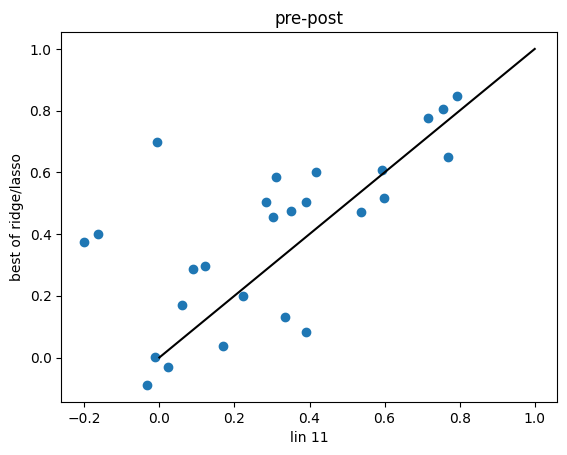

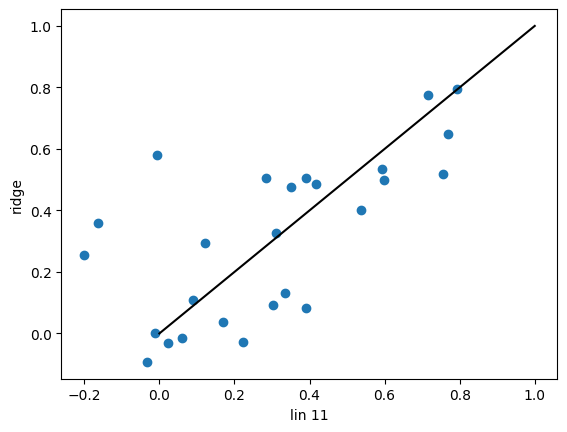

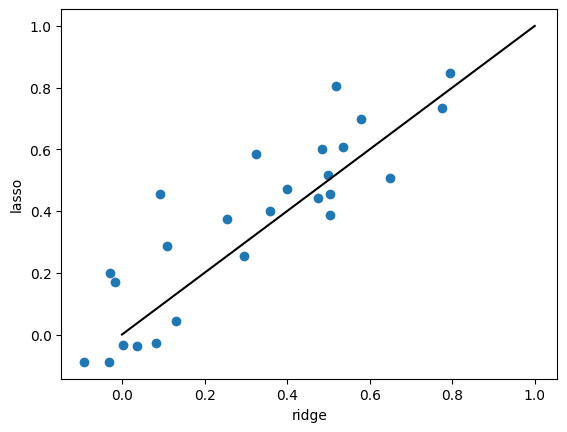

In [8]:
plt.figure()
plt.scatter(lin11_log, np.max(np.array([ridge_all1_log, lasso_all1_log]), axis=0))
plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('lin 11')
plt.ylabel('best of ridge/lasso')
plt.title('pre-post')

plt.figure()
plt.scatter(lin11_log, ridge_all1_log)
plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('lin 11')
plt.ylabel('ridge')


plt.figure()
plt.scatter(ridge_all1_log, lasso_all1_log)
plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('ridge')
plt.ylabel('lasso')



## Post-Post

In [ ]:
import tqdm 
from tqdm import tqdm
for config, roi in tqdm(good_pairs[::-1]):
    plot_summary_figure(config, roi, roi_mask)
    plt.savefig(f'/Users/bhaishahster/Data/xie_lab/code/figures/pre_post_roi:{roi}, config:{config}.pdf')
    plt.show()

In [9]:
lin11_log = []
ridge_all1_log = []
lasso_all1_log = []

import tqdm 
from tqdm import tqdm
for config, roi in tqdm(good_pairs):
    _, r2_lin, _ = get_best_model_nps(LinearRegression, config, roi, 'pre-post', [None], 
                                   False, False)
    _, r2_ridge, _ = get_best_model_nps(Ridge, config, roi, 'post-post', 
                                     np.power(10, np.arange(-6, 3, 0.1)),
                                     False)
    _, r2_lasso, _ = get_best_model_nps(Lasso, config, roi, 'post-post', 
                                                   np.power(10, np.arange(-6, 3, 0.1)), #[0.001,0.01,0.001], 
                                                   False)

    print('models', r2_lin, r2_ridge, r2_lasso)
    lin11_log += [r2_lin]
    ridge_all1_log += [r2_ridge]
    lasso_all1_log += [r2_lasso]
    
    
   
results.update({'post-post': {'ridge_all1': ridge_all1_log, 
                             'lasso_all1': lasso_all1_log}})


  4%|███▊                                                                                              | 1/26 [00:10<04:21, 10.44s/it]

models 0.7564583361002452 0.4053946871475783 0.43346241143025654


  8%|███████▌                                                                                          | 2/26 [00:22<04:36, 11.51s/it]

models 0.311390609388146 0.4429278601645298 0.21306390917083684


 12%|███████████▎                                                                                      | 3/26 [00:32<04:07, 10.76s/it]

models 0.12212888208136197 0.4245482059798149 0.34711697087928606


 15%|███████████████                                                                                   | 4/26 [00:40<03:33,  9.72s/it]

models 0.7701931274208152 0.8198223461553626 0.8883978032848122


 19%|██████████████████▊                                                                               | 5/26 [00:56<04:11, 11.99s/it]

models 0.22189863350825956 0.004315920020365405 0.03715975444889652


 23%|██████████████████████▌                                                                           | 6/26 [01:05<03:36, 10.84s/it]

models 0.416343094900929 0.6806924876464887 0.5926925964900964


 27%|██████████████████████████▍                                                                       | 7/26 [01:15<03:23, 10.71s/it]

models 0.30351536053167427 -0.08960954723669667 -0.049458007160811945


 31%|██████████████████████████████▏                                                                   | 8/26 [01:23<02:55,  9.73s/it]

models 0.059573480616850305 0.24632714050119064 0.7140515841905595


 35%|█████████████████████████████████▉                                                                | 9/26 [01:35<02:56, 10.35s/it]

models 0.598084575397636 0.5992142204656885 0.7234107512226131


 38%|█████████████████████████████████████▎                                                           | 10/26 [01:50<03:12, 12.02s/it]

models 0.7156157519951372 0.709950530370294 0.729111198091274


 42%|█████████████████████████████████████████                                                        | 11/26 [02:03<03:02, 12.15s/it]

models 0.5384282378203566 0.31106930535959265 0.4652216540742907


 46%|████████████████████████████████████████████▊                                                    | 12/26 [02:10<02:30, 10.75s/it]

models 0.38984265757223413 0.626725692733411 0.6530372455475797


 50%|████████████████████████████████████████████████▌                                                | 13/26 [02:26<02:39, 12.27s/it]

models -0.010895865270693195 -0.06435511693511908 -0.08884688090737258


 54%|████████████████████████████████████████████████████▏                                            | 14/26 [02:38<02:25, 12.13s/it]

models -0.006210458411508801 0.8336953620029084 0.8131491974443581


 58%|███████████████████████████████████████████████████████▉                                         | 15/26 [02:47<02:02, 11.16s/it]

models -0.20121716995080452 0.5561649988745432 0.7608651760521297


 62%|███████████████████████████████████████████████████████████▋                                     | 16/26 [02:57<01:47, 10.73s/it]

models -0.16372602228592892 0.35618565186718065 0.5419419845344458


 65%|███████████████████████████████████████████████████████████████▍                                 | 17/26 [03:21<02:14, 14.95s/it]

models -0.031750402873969685 -0.09053815451192282 -0.08884688090737236


 69%|███████████████████████████████████████████████████████████████████▏                             | 18/26 [03:36<01:58, 14.83s/it]

models 0.16987042335141056 0.15559084887285735 0.15926880716434044


 73%|██████████████████████████████████████████████████████████████████████▉                          | 19/26 [03:47<01:35, 13.61s/it]

models 0.283246738362277 0.2780901698448456 0.24354107710306871


 77%|██████████████████████████████████████████████████████████████████████████▌                      | 20/26 [03:55<01:12, 12.16s/it]

models 0.39186170176084634 0.5418911716454695 0.3894598630166838


 81%|██████████████████████████████████████████████████████████████████████████████▎                  | 21/26 [04:03<00:54, 10.86s/it]

models 0.02273169597469027 0.04707417012906234 0.31218207901568684


 85%|██████████████████████████████████████████████████████████████████████████████████               | 22/26 [04:16<00:45, 11.44s/it]

models 0.7924545327336298 0.7510300246716364 0.8509048675170613


 88%|█████████████████████████████████████████████████████████████████████████████████████▊           | 23/26 [04:30<00:36, 12.15s/it]

models 0.3519898517550569 0.5921303636683604 0.802341315680827


 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 24/26 [04:41<00:23, 11.84s/it]

models 0.5930827695782295 0.553762347483846 0.6526656288341228


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 25/26 [04:55<00:12, 12.63s/it]

models 0.33389207287846057 0.12087893116234472 0.1149627887032536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [05:06<00:00, 11.80s/it]

models 0.08986304994953886 0.21191183528042323 0.4316087792569936


Text(0, 0.5, 'lasso')

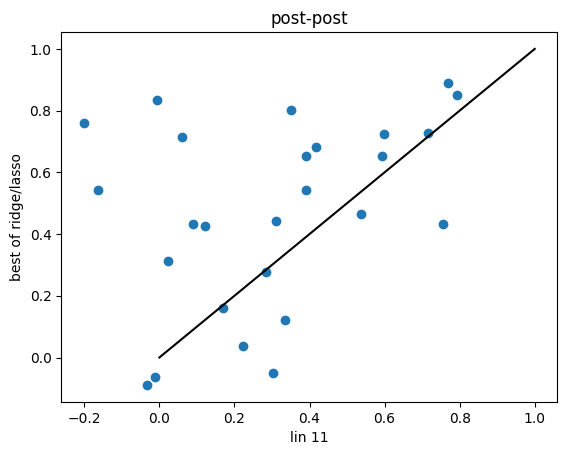

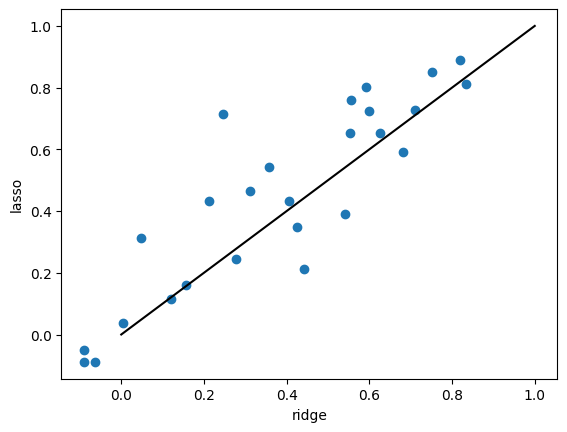

In [10]:

plt.figure()
plt.scatter(lin11_log, np.max(np.array([ridge_all1_log, lasso_all1_log]), axis=0))
plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('lin 11')
plt.ylabel('best of ridge/lasso')
plt.title('post-post')

plt.figure()
plt.scatter(ridge_all1_log, lasso_all1_log)
plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('ridge')
plt.ylabel('lasso')


